# Natural Language Inference (NLI)


# Readme

This notebook implements and compares three Natural Language Inference (NLI) models: **BiLSTM**, **ESIM**, and a custom **Transformer encoder**. The task is to determine whether a given hypothesis is entailed or neutral with respect to a premise.

### Project Overview

| Section | Description |
|----------|-------------|
| **1. Dataset Processing** | Data loading, cleaning, vocabulary building, and embedding preparation |
| **2. Model Implementation** | Model construction for BiLSTM, ESIM, and Transformer architectures |
| **3. Testing and Evaluation** | Model evaluation, comparison, visualization, and ablation studies |

### Model Summary

| Model | Description | Main Components |
|--------|--------------|----------------|
| **BiLSTM** | Baseline sequence encoder | Bidirectional LSTM with mean/max pooling |
| **ESIM** | Enhanced inference model with attention | BiLSTM encoder, cross-attention, and interaction features |
| **Transformer** | Attention-based encoder | Multi-head self-attention, positional embeddings, and attentive pooling |

### Experimental Flow

1. **Data Processing**  
   Load, clean, and tokenize NLI data; construct vocabulary and pretrained embeddings.  
2. **Model Implementation**  
   Define and initialize the BiLSTM, ESIM, and Transformer models.  
3. **Training and Fine-tuning**  
   Train models with consistent settings and perform parameter tuning.  
4. **Evaluation and Analysis**  
   Compare model results and perform qualitative and ablation analyses.

### Notes

- All experiments share the same dataset splits and pretrained embeddings.  
- Trained models are saved under the model/ directory:  
  bilstm_best.pt, sim_best.pt, and transformer_best.pt.

This notebook is self-contained, modular, and designed for reproducible NLI experiments.

# 1.Dataset Processing

This section covers all preprocessing steps required to prepare the dataset for model training and evaluation.  
The Natural Language Inference (NLI) dataset contains premise–hypothesis pairs labeled as **entailment** or **neutral**.  

Key steps include:
1. Loading and inspecting the dataset splits (train, validation, test).  
2. Describing data distribution and basic statistics.  
3. Performing tokenization and preprocessing.  
4. Building the vocabulary and constructing pretrained embedding matrices using FastText.  

All processed data and embeddings are reused consistently across all model architectures.

### 1.1 Data Loading

This section loads the Natural Language Inference (NLI) dataset from Google Drive and organizes it into train, validation, and test sets.
All data files are stored in JSON format and loaded into pandas DataFrames for further preprocessing.

In [1]:
# Install required package
!pip install -q gensim

In [2]:
# Import required libraries
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import json
import os

# Authenticate and connect to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Creat directory structure for data
os.makedirs("/content/data/raw", exist_ok=True)
os.makedirs("/content/data/processed", exist_ok=True)

# Google Drive file IDs
files = {
    'train.json': '1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv',
    'validation.json': '15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX',
    'test.json': '179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-'
}

# Download the files from Google Drive
for filename, file_id in files.items():
    downloaded = drive.CreateFile({'id': file_id})
    save_path = f"/content/data/raw/{filename}"
    downloaded.GetContentFile(save_path)

# Load JSON files into Python objects
with open("data/raw/train.json", "r") as f:
    train_data = json.load(f)

with open("data/raw/validation.json", "r") as f:
    val_data = json.load(f)

with open("data/raw/test.json", "r") as f:
    test_data = json.load(f)

In [3]:
# Convert JSON objects to pandas DataFrames
def load_nli_split(path):
    with open(path, "r") as f:
        obj = json.load(f)

    if isinstance(obj, dict) and all(isinstance(v, dict) for v in obj.values()):
        df = pd.DataFrame(obj)
        df.index.name = "id"
        df = df.reset_index()

    elif isinstance(obj, list):
        df = pd.DataFrame(obj)
        if "id" not in df.columns:
            df.insert(0, "id", range(len(df)))
    else:
        raise ValueError("Unsupported JSON structure")

    if "label" in df.columns:
        label_map = {0: "neutral", 1: "entails", "0": "neutral", "1": "entails"}
        df["label"] = df["label"].map(label_map).fillna(df["label"])

    return df

train_df = load_nli_split("data/raw/train.json")
val_df   = load_nli_split("data/raw/validation.json")
test_df  = load_nli_split("data/raw/test.json")

In [4]:
# Basic dataset info and sample inspection
print("Train shape:", train_df.shape)
print("Sample data:")
print(train_df.head())

print("Val shape:", val_df.shape)
print("Sample data:")
print(val_df.head())

print("Test shape:", test_df.shape)
print("Sample data:")
print(test_df.head())

Train shape: (23088, 4)
Sample data:
  id                                            premise  \
0  0  Pluto rotates once on its axis every 6.39 Eart...   
1  1  ---Glenn =====================================...   
2  2  geysers - periodic gush of hot water at the su...   
3  3  Facts: Liquid water droplets can be changed in...   
4  4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  
Val shape: (1304, 4)
Sample data:
  id                                            premise  \
0  0  An introduction to atoms and elements, compoun...   
1  1  Wavelength The distance between two consecutiv...   
2  2      hum

Each example consists of a **premise**, a **hypothesis**, and a **label** (entails or neutral).  
The training set contains **23,088 samples**, with 1,304 and 2,126 instances in validation and test sets.

### 1.2 Dataset Description & Distribution

This section explores the dataset structure, class distribution, and sentence length statistics.  
Understanding the label balance and sentence length helps to determine suitable preprocessing and padding strategies.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Label Distribution Visualization

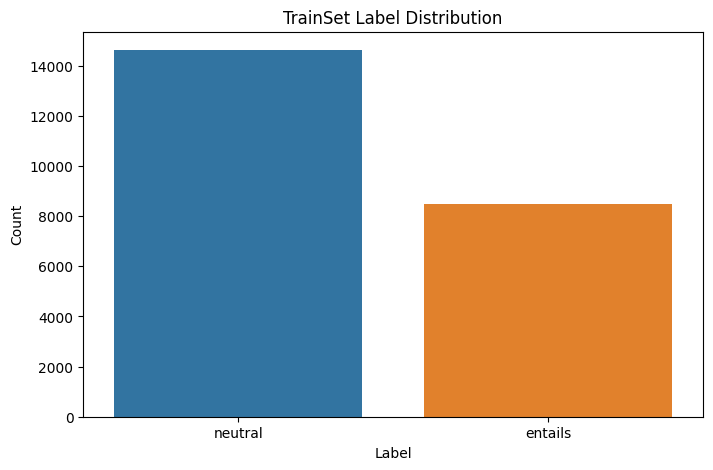

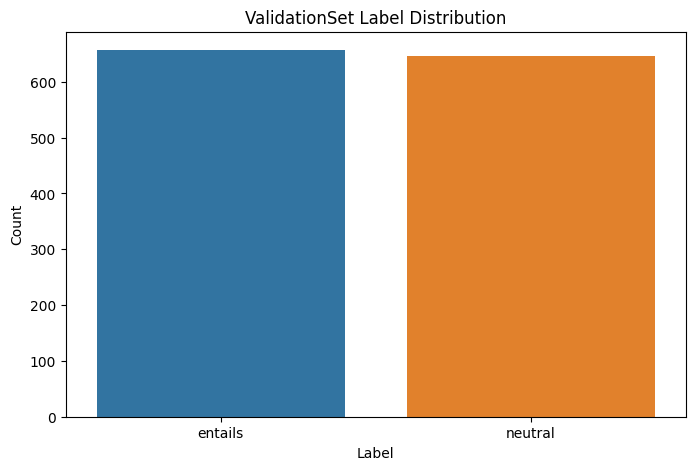

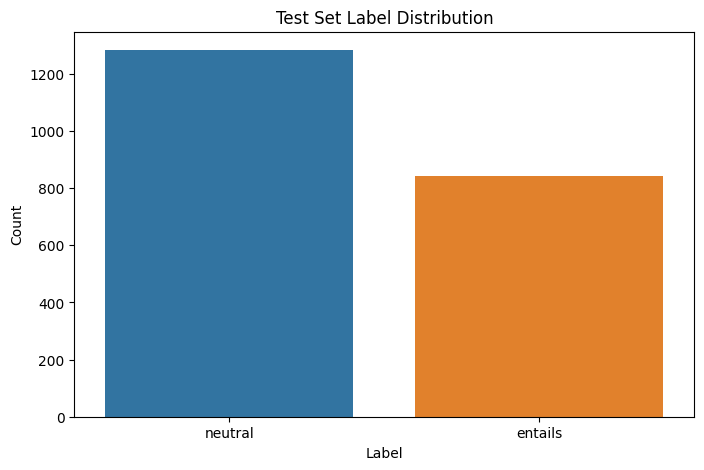

In [6]:
# Label distribution
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, legend=False)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_label_distribution(train_df, "TrainSet Label Distribution")
plot_label_distribution(val_df, "ValidationSet Label Distribution")
plot_label_distribution(test_df, "Test Set Label Distribution")

The dataset is **binary-labeled**, with samples classified as either *entails* or *neutral*.  

Sentence Length Statistics

In [7]:
# Sentence length distribution
def plot_sentence_length_distribution(df, title):
    # Create a completely new dataframe with the required columns
    premise_lengths = df['premise'].apply(lambda x: len(nltk.word_tokenize(x)))
    hypothesis_lengths = df['hypothesis'].apply(lambda x: len(nltk.word_tokenize(x)))

    # Create new dataframe to avoid any warnings
    plot_data = pd.DataFrame({
        'premise_length': premise_lengths,
        'hypothesis_length': hypothesis_lengths
    })

    plt.figure(figsize=(12, 6))
    sns.histplot(plot_data['premise_length'], color='blue', label='Premise', kde=True, stat="count", bins=30)
    sns.histplot(plot_data['hypothesis_length'], color='orange', label='Hypothesis', kde=True, stat="count", bins=30)
    plt.title(title)
    plt.xlabel('Sentence Length (words)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

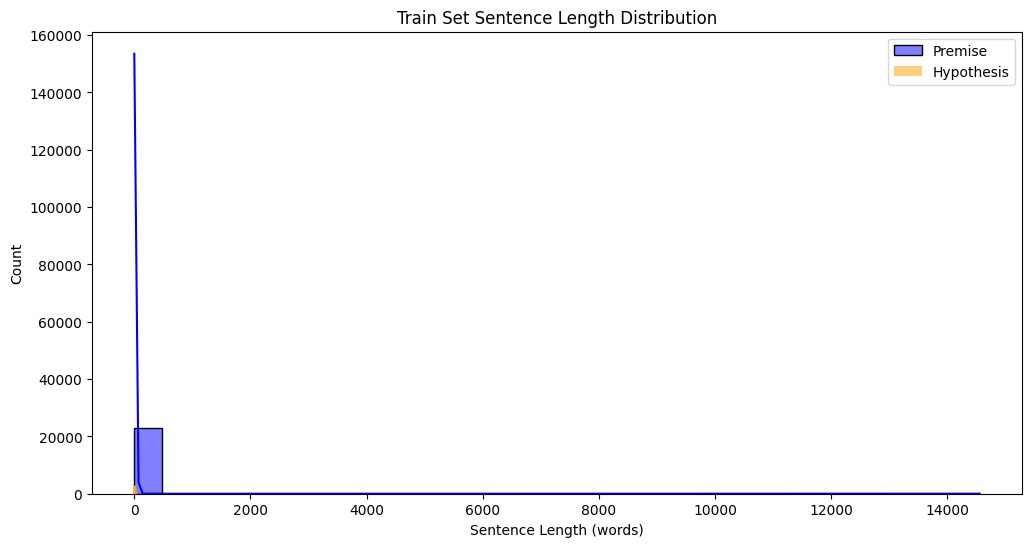

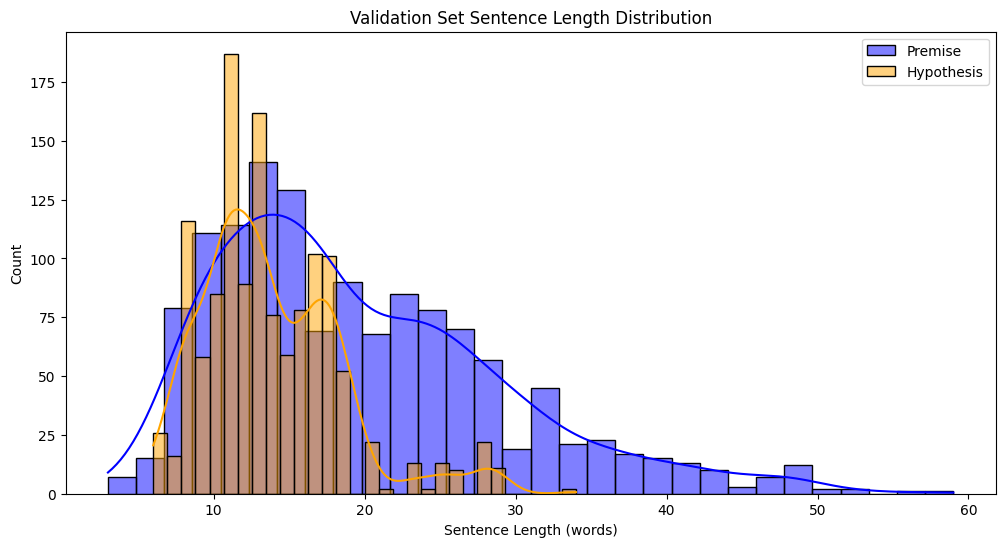

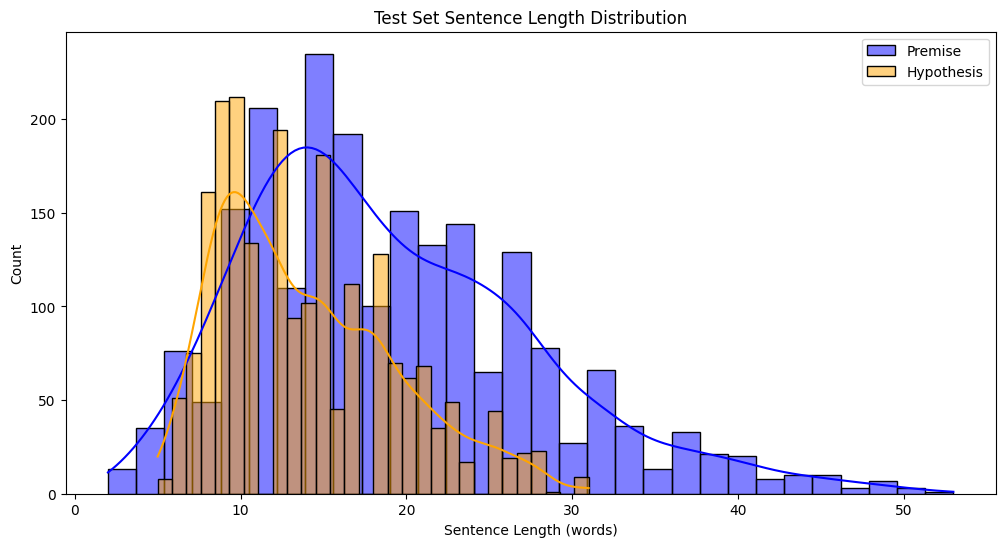

In [8]:
plot_sentence_length_distribution(train_df, "Train Set Sentence Length Distribution")
plot_sentence_length_distribution(val_df, "Validation Set Sentence Length Distribution")
plot_sentence_length_distribution(test_df, "Test Set Sentence Length Distribution")

On average, premises contain more tokens than hypotheses.  
A few extremely long premises are observed, suggesting the need for truncation.

Summary Statistics (Train Set)

In [9]:
# Summary statistics of sentence lengths of train set
train_df["premise_length"] = train_df["premise"].apply(lambda x: len(nltk.word_tokenize(x)))
train_df["hypothesis_length"] = train_df["hypothesis"].apply(lambda x: len(nltk.word_tokenize(x)))
print(train_df[["premise_length", "hypothesis_length"]].describe())

       premise_length  hypothesis_length
count    23088.000000       23088.000000
mean        20.801499          13.130501
std        116.024158           4.796214
min          1.000000           4.000000
25%         12.000000          10.000000
50%         18.000000          12.000000
75%         25.000000          16.000000
max      14556.000000          38.000000


In [10]:
# Determine 99% cutoff length for each field
for col in ['premise_length', 'hypothesis_length']:
    max_len = int(train_df[col].quantile(0.99))
    print(f"99% lengths of {col.split('_')[0]} have max {max_len} words")

99% lengths of premise have max 48 words
99% lengths of hypothesis have max 27 words


99% of the training samples have **premises ≤ 48 words** and **hypotheses ≤ 27 words**.  
To reduce noise and memory usage, longer sentences are filtered out.

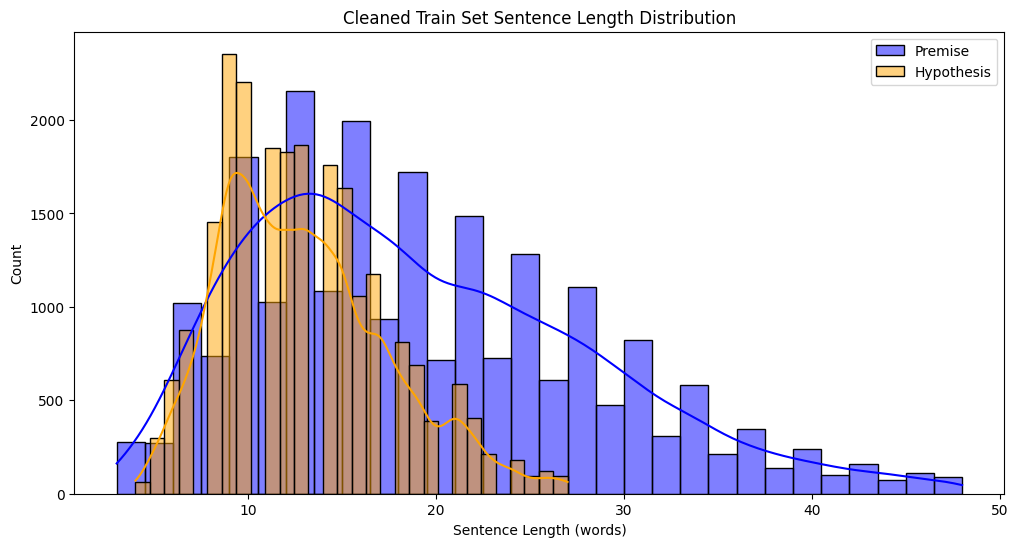

In [11]:
# filter out sentences longer than 99% length
min_len = 3
max_len_p = 48
max_len_h = 27
cleaned_df = train_df[
    (train_df['premise_length'] >= min_len) & (train_df['premise_length'] <= max_len_p) &
    (train_df['hypothesis_length'] >= min_len) & (train_df['hypothesis_length'] <= max_len_h)
]
train_df = cleaned_df
plot_sentence_length_distribution(train_df, "Cleaned Train Set Sentence Length Distribution")

In [12]:
print(f"After cleaning: {len(train_df)} samples remain.")
print(train_df[["premise_length", "hypothesis_length"]].describe())

After cleaning: 22613 samples remain.
       premise_length  hypothesis_length
count    22613.000000       22613.000000
mean        19.070446          12.955203
std          9.140061           4.485011
min          3.000000           4.000000
25%         12.000000           9.000000
50%         18.000000          12.000000
75%         25.000000          16.000000
max         48.000000          27.000000


After filtering, **22,613 samples** remain in the training set.  
This cleaned dataset is used for all subsequent model training and evaluation.

### 1.3 Data Preprocessing

This section prepares the dataset for model input by handling missing data, removing duplicates,  
and applying text preprocessing including tokenization, lowercasing, and lemmatization.

Missing data

In [13]:
# Check for missing data
def check_missing_data(df, title):
    missing_counts = df.isnull().sum()
    if missing_counts.sum() == 0:
        print(f"No missing data in {title}.")
    else:
        print(f"Missing data in {title}:")
        print(missing_counts[missing_counts > 0])

check_missing_data(train_df, "Train Set")
check_missing_data(val_df, "Validation Set")
check_missing_data(test_df, "Test Set")

No missing data in Train Set.
No missing data in Validation Set.
No missing data in Test Set.


No missing values are detected in any dataset split.

Remove Duplicate Samples

In [14]:
def remove_duplicates(df, name="Dataset"):
    before_count = len(df)
    df = df.drop_duplicates()
    after_count = len(df)
    print(f"{name}: Removed {before_count - after_count} duplicate rows (remaining {after_count})")
    return df

train_df = remove_duplicates(train_df, "Train Set")
val_df   = remove_duplicates(val_df, "Validation Set")
test_df  = remove_duplicates(test_df, "Test Set")

Train Set: Removed 0 duplicate rows (remaining 22613)
Validation Set: Removed 0 duplicate rows (remaining 1304)
Test Set: Removed 0 duplicate rows (remaining 2126)


All three splits contain unique samples.  
After deduplication, the training, validation, and test sets remain unchanged.

**Text Preprocessing**

Tokenization, Lowercasing, Lemmatization

In [15]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Setup preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess(df):
    # Create a copy of the input DataFrame to avoid warnings
    df_copy = df.copy()
    processed_data = []

    for _, row in df_copy.iterrows():
        row_data = {}

        for col_name in ['premise', 'hypothesis']:
            # Step 1: Clean and lowercase
            cleaned = re.sub(r"[^a-z0-9]+", " ", row[col_name].lower())

            # Step 2: Tokenize, filter, lemmatize
            tokens = word_tokenize(cleaned)
            tokens = [t for t in tokens if t not in stop_words and not t.isnumeric()]
            tokens = [lemmatizer.lemmatize(t) for t in tokens]

            row_data[f'{col_name}_tokens'] = tokens

        row_data['label'] = row['label']
        processed_data.append(row_data)

    # Convert to DataFrame
    result_df = pd.DataFrame(processed_data)
    return result_df[["premise_tokens", "hypothesis_tokens", "label"]]

# Apply to datasets
df_train = preprocess(train_df)
df_val = preprocess(val_df)
df_test = preprocess(test_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
# save preprocessed data
df_train.to_csv("data/processed/train_processed.csv", index=False)
df_val.to_csv("data/processed/val_processed.csv", index=False)
df_test.to_csv("data/processed/test_processed.csv", index=False)

print("Train sample:")
print(df_train.head())

Train sample:
                                      premise_tokens  \
0          [pluto, rotates, axis, every, earth, day]   
1            [glenn, per, day, earth, rotates, axis]   
2  [geyser, periodic, gush, hot, water, surface, ...   
3  [fact, liquid, water, droplet, changed, invisi...   
4  [comparison, earth, rotates, axis, per, day, r...   

                                   hypothesis_tokens    label  
0             [earth, rotates, axis, time, one, day]  neutral  
1             [earth, rotates, axis, time, one, day]  entails  
2  [surface, sun, much, hotter, almost, anything,...  neutral  
3  [evaporation, responsible, changing, liquid, w...  entails  
4             [earth, rotates, axis, time, one, day]  entails  


Each text is now represented as a list of lemmatized tokens,ready for embedding and vocabulary construction in the next step.

### 1.4 Vocabulary & Embedding Preparation

This section constructs the vocabulary from all tokenized texts and trains a **FastText embedding model** on the combined corpus for downstream model initialization.

In [17]:
# Combine all tokenized text from train, val, and test sets
cols = ['premise_tokens', 'hypothesis_tokens']
temp_df = pd.concat([df_train[cols], df_val[cols], df_test[cols]], ignore_index=True)

premise_list = temp_df['premise_tokens'].tolist()
hypothesis_list = temp_df['hypothesis_tokens'].tolist()

# Merge all sentences into one large corpus
corpus = premise_list + hypothesis_list

print(f"Total sentences in corpus: {len(corpus)}")
print(f"Example sentence tokens: {corpus[0][:20]}")

Total sentences in corpus: 52086
Example sentence tokens: ['pluto', 'rotates', 'axis', 'every', 'earth', 'day']


The combined corpus contains **52,086 sentences** for a consistent embedding vocabulary.

In [18]:
# Build vocabulary statistics
vocab = set(token for sent in corpus for token in sent)
print(f"Vocabulary size: {len(vocab):,}")

Vocabulary size: 17,779


The constructed vocabulary contains approximately **17,779 unique tokens**.  
This vocabulary will be used to align embeddings across all models.

Train FastText Embeddings

In [19]:
# Construct and save pretrained embedding matrices - FastText
from gensim.models import FastText
os.makedirs("model", exist_ok=True)

# Initialize FastText model and use skip-gram method (sg=1)
ft_sg = FastText(corpus, vector_size = 300, window = 5,
                 min_count=5, workers=4, sg=1, epochs=30)

# Save trained FastText model
ft_sg.save("model/fasttext_sg.model")

The FastText model is trained with a **300-dimensional skip-gram configuration**, providing context-aware word embeddings for all subsequent models (BiLSTM, ESIM, Transformer).

# 2. Model Implementation

This section presents the implementation of three model architectures for the NLI (Natural Language Inference) task:
- **BiLSTM Baseline** — a sequence encoding model using bidirectional LSTMs.  
- **ESIM (Enhanced Sequential Inference Model)** — a powerful attention-based model for pairwise reasoning.  
- **Transformer-based Model** — a self-attention architecture inspired by the Transformer encoder.

Each model shares the same preprocessed dataset and FastText embeddings for fair comparison.

In [20]:
# Environment setup
import torch
import os
import random

# Devise setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Global random seed
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed}")

set_seed(42)

Using device: cuda
Global seed set to 42


Data and Embedding Setup

The processed datasetand the pre-trained FastText embeddings (generated in **Section 1Dataset Processing**) are downloaded from Google Drive.

In [21]:
# Download files
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from gensim.models import FastText

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Google Drive file IDs
files = {
    "train": "1dSRs_zVzZ6GegidM_8mYW1CaThguukQ5",
    "val": "1N5KZ6SixGGEOEEjrhfDfBf2eyhfkl83B",
    "test": "1-FyjVFQX5jsN1cIpYyMB1to_loIbFkmo",
    "fasttext": "1Jfp84SDCefW0XHhtOijnNx0TCKfdG_Ef",
    "fasttext_npy": "10msX7FDKFLrt8gD06osOgGWdlOUS8RcH"
}

os.makedirs("data/processed", exist_ok=True)
os.makedirs("model", exist_ok=True)

for name, file_id in files.items():
    downloaded = drive.CreateFile({"id": file_id})
    if name in ["train", "val", "test"]:
        downloaded.GetContentFile(f"data/processed/{name}_processed.csv")
    elif name == "fasttext":
        downloaded.GetContentFile("model/fasttext_sg.model")
    elif name == "fasttext_npy":
        downloaded.GetContentFile("model/fasttext_sg.model.vectors_ngrams.npy")

## 2.1 Bi-LSTM Model

The BiLSTM model serves as a baseline for the NLI task. It encodes both the premise and hypothesis using bidirectional LSTMs, and compares their representations through concatenation and fully connected layers for classification.

### 2.1.1 Data Preparation

This section prepares tokenized input data and converts it into numerical format for model consumption.

Pre-trained FastText embeddings are loaded, and all sentences are encoded, padded, and packaged into PyTorch DataLoaders.

In [22]:
import pandas as pd
import torch
from gensim.models import FastText

# Load processed datasets
df_train = pd.read_csv("data/processed/train_processed.csv")
df_val   = pd.read_csv("data/processed/val_processed.csv")
df_test  = pd.read_csv("data/processed/test_processed.csv")

# Load pretrained FastText embeddings
ft_model = FastText.load("model/fasttext_sg.model")

In [23]:
# Convert token columns from string to Python lists
import ast
def extract_text(df):
    col1 = df.iloc[:, 0].apply(ast.literal_eval)
    col2 = df.iloc[:, 1].apply(ast.literal_eval)
    sentences = (col1 + col2).tolist()

    words = [word.lower() for sentence in sentences for word in sentence if word.isalpha()]
    tags = np.where(df.iloc[:, 2] == "neutral", 0, 1).tolist()

    return sentences, words, tags

In [24]:
# Extract tokens and labels
sentences_train, words_train, tags_train = extract_text(df_train)
sentences_test, words_test, tags_test = extract_text(df_test)
sentences_val, words_val, tags_val = extract_text(df_val)

In [25]:
# Build vocabulary and mappings
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(set(words_train)))
word2index = {w: i for i, w in enumerate(vocab)} # Dictionary for mapping a word to a unique word index

word2index['[PAD]'] = 0
word2index['[OOV]'] = 1

tag2index = {t: i for i, t in enumerate(list(set(tags_train)))}
index2tag = {i: t for t, i in tag2index.items()}

In [26]:
# Encode sentences into index sequences
def encode_sentences(sentences):
    res = []
    for sent in sentences:
        temp = [ word2index[word.lower()] if word.lower() in word2index else word2index['[OOV]'] for word in sent]
        res.append(temp)
    return res

# Encode both train and test set using the conversion function encode_sentences() defined above
train_sentences_encoded = encode_sentences(sentences_train)
val_sentences_encoded = encode_sentences(sentences_val)
test_sentences_encoded = encode_sentences(sentences_test)

In [27]:
# Determine max sequence length based on training data
max_length= len(max(train_sentences_encoded, key=len))
print(f"Max sequence length: {max_length}")

Max sequence length: 43


In [28]:
# Padding function to ensure all sequences have the same length
def pad_sequence(seq_list, max_length, index_dict):
    res = []
    for seq in seq_list:
        temp = seq[:]
        # If original length is greater than the defined max length, trim it
        if len(seq)>max_length:
            res.append(temp[:max_length])
        else: # If original length is less than the defined max length, pad it
            temp += [index_dict['[PAD]']] * (max_length - len(seq))
            res.append(temp)
    return np.array(res)

train_sentences_encoded_pad = pad_sequence(train_sentences_encoded, max_length, word2index)
val_sentences_encoded_pad = pad_sequence(val_sentences_encoded, max_length, word2index)
test_sentences_encoded_pad = pad_sequence(test_sentences_encoded, max_length, word2index)

In [29]:
# Build DataLoaders
from torch.utils.data import TensorDataset, DataLoader

def build_loader(dataset, padded_sequences, labels, batch_size=128, shuffle=False, generator=None):
    tags_y_np = np.array(labels)
    dataset = TensorDataset(torch.from_numpy(padded_sequences), torch.from_numpy(tags_y_np))

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, generator=generator)

g = torch.Generator()
g.manual_seed(42)
train_loader = build_loader(df_train, train_sentences_encoded_pad, tags_train, batch_size=128, shuffle=True, generator=g)
val_loader = build_loader(df_val, val_sentences_encoded_pad, tags_val, batch_size=128, shuffle=True, generator=g)
test_loader = build_loader(df_test, test_sentences_encoded_pad, tags_test, batch_size=128, shuffle=True, generator=g)

In [30]:
# Build embedding matrix
emb_dim = 300
emb_table  = np.array([ft_model.wv[term] if term in ft_model.wv else [0]*emb_dim for term in vocab])
print(f"Embedding matrix shape: {emb_table.shape}")

Embedding matrix shape: (16419, 300)


### 2.1.2 Model Architecture

The BiLSTM model encodes token sequences into contextualized representations through a two-layer bidirectional LSTM. Pre-trained FastText embeddings are used as static word representations, followed by a linear projection for classification.

In [31]:
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()

        # Embedding layer initialized with pre-trained FastText weights
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.word_embeddings.weight.requires_grad = False  # freeze embeddings

        # Two-layer bidirectional LSTM encoder
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Output layer: maps BiLSTM outputs to tag logits
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)  # [batch, seq, emb_dim]
        lstm_out, _ = self.lstm(embeds)          # [batch, seq, hidden*2]
        tag_space = self.hidden2tag(lstm_out)    # [batch, seq, num_classes]
        return tag_space

### 2.1.3 Training Loop

The BiLSTM model is trained using the Adam optimizer with cross-entropy loss. At each epoch, the model is evaluated on the validation set, and results are reported in a consistent format for comparison with later models.

In [32]:
# Training & Evaluation Functions
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for sentence, targets in train_loader:
        sentence, targets = sentence.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(sentence)
        outputs = outputs[:, -1, :]               # last time step for classification
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # optional
        optimizer.step()

        batch_size = sentence.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (outputs.argmax(dim=-1) == targets).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = 100 * total_correct / total_samples
    return avg_loss, avg_acc

@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for sentence, targets in data_loader:
        sentence, targets = sentence.to(device), targets.to(device)
        outputs = model(sentence)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, targets)

        batch_size = sentence.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (outputs.argmax(dim=-1) == targets).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = 100 * total_correct / total_samples
    return avg_loss, avg_acc

In [33]:
# Baseline Training Loop
EMBEDDING_DIM = emb_table.shape[-1]
HIDDEN_DIM = 256
model_lstm = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model_lstm, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_lstm, val_loader, criterion, device)

    print(f"Epoch {epoch:2d} | Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
          f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

print("\nBaseline training completed.")

Epoch  1 | Train loss=0.6602 | Train acc=63.03% | Val loss=0.7137 | Val acc=49.62%
Epoch  2 | Train loss=0.6502 | Train acc=63.22% | Val loss=0.7000 | Val acc=49.62%
Epoch  3 | Train loss=0.6583 | Train acc=63.22% | Val loss=0.7260 | Val acc=49.62%
Epoch  4 | Train loss=0.6583 | Train acc=63.22% | Val loss=0.7487 | Val acc=49.62%
Epoch  5 | Train loss=0.6474 | Train acc=63.21% | Val loss=0.6953 | Val acc=49.62%
Epoch  6 | Train loss=0.5923 | Train acc=69.11% | Val loss=0.6170 | Val acc=70.55%
Epoch  7 | Train loss=0.5291 | Train acc=74.99% | Val loss=0.6061 | Val acc=69.94%
Epoch  8 | Train loss=0.4738 | Train acc=78.55% | Val loss=0.6776 | Val acc=65.18%
Epoch  9 | Train loss=0.4277 | Train acc=81.39% | Val loss=0.6561 | Val acc=66.56%
Epoch 10 | Train loss=0.3827 | Train acc=83.65% | Val loss=0.6973 | Val acc=68.10%
Epoch 11 | Train loss=0.3393 | Train acc=85.97% | Val loss=0.6842 | Val acc=67.41%
Epoch 12 | Train loss=0.3031 | Train acc=87.90% | Val loss=0.7134 | Val acc=67.79%
Epoc


The BiLSTM baseline demonstrates steady improvement during early epochs, reaching its best validation accuracy (≈69%) around epoch 6–9. After this point, training accuracy continues to increase while validation accuracy plateaus or slightly drops, indicating mild overfitting. These results establish a solid reference point for subsequent fine-tuning and model comparison.

### 2.1.4 Fine-tuning

The BiLSTM model is fine-tuned with a small grid search over hidden size, batch size, and learning rate. The best-performing configuration on the validation set is selected and saved for later evaluation.

In [34]:
import os
import copy
import pandas as pd
from itertools import product

# Search space for Bi-LSTM hyperparameters
param_grid = {
    "hidden_dim": [256, 512],
    "batch_size": [128, 256],
    "learning_rate": [1e-3],
}
num_epochs = 20

search_results = []
best_global_model = None
best_global_config = None
best_global_val_acc = -1.0

for run_idx, values in enumerate(product(*param_grid.values()), start=1):
    config = dict(zip(param_grid.keys(), values))
    print(f"\n=== Running configuration {run_idx}: {config} ===")

    # Build DataLoader for this configuration
    train_loader = build_loader(
        df_train,
        train_sentences_encoded_pad,
        tags_train,
        batch_size=config["batch_size"],
        shuffle=True,
    )

    # Initialize model
    model = LSTMTagger(
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=config["hidden_dim"],
        vocab_size=len(word2index),
        tagset_size=len(tag2index),
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    best_val_acc = -1.0
    best_model = None
    final_train_loss, final_train_acc, final_val_loss = None, None, None

    # Training loop for this config
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch:2d} | Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
              f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

        # Record latest epoch metrics (for summary table)
        final_train_loss = train_loss
        final_train_acc = train_acc
        final_val_loss = val_loss

        # Save best val model for this config
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)

    print(f"→ Best Validation Accuracy for config {config}: {best_val_acc:.2f}%")
    search_results.append({
        **config,
        "train_loss": final_train_loss,
        "train_acc": final_train_acc,
        "val_loss": final_val_loss,
        "val_acc": best_val_acc
    })

    # Track global best
    if best_val_acc > best_global_val_acc:
        best_global_val_acc = best_val_acc
        best_global_config = config
        best_global_model = copy.deepcopy(best_model)

# Save best model (entire model object)
os.makedirs("model", exist_ok=True)
torch.save(best_global_model, "model/bilstm_best.pt")

print("\nGrid search completed.")
print(f"Best configuration (by validation accuracy): {best_global_config}")
print(f"Best validation accuracy: {best_global_val_acc:.2f}%")

# Show summary table
results_df = pd.DataFrame(search_results)
print(results_df.sort_values(by="val_acc", ascending=False).reset_index(drop=True))


=== Running configuration 1: {'hidden_dim': 256, 'batch_size': 128, 'learning_rate': 0.001} ===
Epoch  1 | Train loss=0.6591 | Train acc=63.10% | Val loss=0.7219 | Val acc=49.62%
Epoch  2 | Train loss=0.6585 | Train acc=63.22% | Val loss=0.7255 | Val acc=49.62%
Epoch  3 | Train loss=0.6565 | Train acc=63.22% | Val loss=0.7404 | Val acc=49.62%
Epoch  4 | Train loss=0.6380 | Train acc=64.78% | Val loss=0.6575 | Val acc=65.41%
Epoch  5 | Train loss=0.5464 | Train acc=73.29% | Val loss=0.6492 | Val acc=66.18%
Epoch  6 | Train loss=0.4786 | Train acc=77.93% | Val loss=0.6338 | Val acc=66.87%
Epoch  7 | Train loss=0.4181 | Train acc=81.56% | Val loss=0.6688 | Val acc=66.03%
Epoch  8 | Train loss=0.3670 | Train acc=84.15% | Val loss=0.6533 | Val acc=67.10%
Epoch  9 | Train loss=0.3300 | Train acc=86.37% | Val loss=0.6719 | Val acc=67.64%
Epoch 10 | Train loss=0.2977 | Train acc=87.58% | Val loss=0.7136 | Val acc=66.26%
Epoch 11 | Train loss=0.2595 | Train acc=89.86% | Val loss=0.7712 | Val a

**Fine-Tuning Results Summary**

The BiLSTM fine-tuning phase explored different configurations of hidden size and batch size while keeping the learning rate fixed at **1e-3**. A total of four configurations were evaluated to examine model capacity and training stability.

**Key findings:**
- Validation accuracy improved from the **baseline 69% → 71.0%**,  
  showing moderate gains from increased hidden dimension and batch size.  
- The best configuration achieved **71.01% validation accuracy** with hidden_dim = 512, batch_size = 256, and learning_rate = 1e-3.  
- Larger hidden states generally enhanced representational power,  
  while overly small batches led to noisier convergence.  
- The complete fine-tuning process took approximately **16 minutes** on GPU.

Overall, fine-tuning the BiLSTM provided a small but consistent improvement, confirming that deeper and wider architectures better capture semantic alignment in NLI tasks.

## 2.2 ESIM Model

Building upon the BiLSTM baseline, this section introduces the **Enhanced Sequential Inference Model (ESIM)**, a more expressive architecture specifically designed for Natural Language Inference (NLI).  

ESIM improves over traditional BiLSTM models by incorporating **attention mechanisms** and **inference composition**, allowing the model to capture fine-grained alignment between premise and hypothesis sentences.  

### 2.2.1 Data Preparation

The ESIM model requires tokenized sentence pairs and label indices as inputs.

This section loads the preprocessed datasets, reconstructs the token lists, builds a vocabulary, and defines dataset and dataloader structures for training.

In [35]:
import pandas as pd
import torch
from gensim.models import FastText
from itertools import chain
import math, random, time, numpy as np, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from collections import OrderedDict

# Load processed datasets
df_train = pd.read_csv("data/processed/train_processed.csv")
df_val   = pd.read_csv("data/processed/val_processed.csv")
df_test  = pd.read_csv("data/processed/test_processed.csv")

# Load pretrained FastText embeddings
ft_model = FastText.load("model/fasttext_sg.model")

In [36]:
import ast

# Convert stored token lists from string to Python list objects
def normalize_df_tokens(df):
    df = df.copy()
    df["premise_tokens"] = df["premise_tokens"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    df["hypothesis_tokens"] = df["hypothesis_tokens"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    return df

# Normalize all dataset splits
df_train = normalize_df_tokens(df_train)
df_val = normalize_df_tokens(df_val)
df_test = normalize_df_tokens(df_test)

# Label encoding
labels_esim = sorted(df_train["label"].unique().tolist())
label_to_ix_esim = {y: i for i, y in enumerate(labels_esim)}
ix_to_label_esim = {i: y for y, i in label_to_ix_esim.items()}

print("Label mapping:", label_to_ix_esim)

Label mapping: {'entails': 0, 'neutral': 1}


**Vocabulary Construction**

The vocabulary is built from all tokens appearing in the training set. Special tokens <PAD> and <UNK> are reserved for padding and unknown words.

In [37]:
# Build a token-to-index dictionary
def build_vocab_esim(df_train):
    all_tokens = list(chain.from_iterable(df_train["premise_tokens"])) + \
                 list(chain.from_iterable(df_train["hypothesis_tokens"]))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for w in set(all_tokens):
        if w not in vocab:
            vocab[w] = len(vocab)
    return vocab

word_to_ix_esim = build_vocab_esim(df_train)
vocab_size_esim = len(word_to_ix_esim)
print("ESIM Vocab size:", vocab_size_esim)
print("Example vocab entries:", list(word_to_ix_esim.keys())[:15])

ESIM Vocab size: 16708
Example vocab entries: ['<PAD>', '<UNK>', 'resting', 'formic', 'cooker', 'vision', 'childhood', 'polishing', 'subterminal', 'ejection', 'polonium', 'grub', 'contracted', 'dismissal', 'ocean']


**Dataset and DataLoader Setup**

We create a custom dataset class and a collation function for dynamic padding.

This allows efficient batching of premise–hypothesis pairs with different lengths.

In [38]:
# Dataset class
class NLIPairDataset_esim(Dataset):
    def __init__(self, df, word_to_ix, label_to_ix):
        self.samples = []
        for _, row in df.iterrows():
            p = [word_to_ix.get(w, word_to_ix["<UNK>"]) for w in row["premise_tokens"]]
            h = [word_to_ix.get(w, word_to_ix["<UNK>"]) for w in row["hypothesis_tokens"]]
            y = label_to_ix[row["label"]]
            self.samples.append((p, h, y))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

# Collate function for dynamic padding and mask generation
def collate_fn_esim(batch):
    ps, hs, ys = zip(*batch)
    p_lens = torch.tensor([len(x) for x in ps], dtype=torch.long)
    h_lens = torch.tensor([len(x) for x in hs], dtype=torch.long)
    max_p, max_h = max(p_lens).item(), max(h_lens).item()
    PAD = word_to_ix_esim["<PAD>"]

    p_pad = torch.full((len(ps), max_p), PAD, dtype=torch.long)
    h_pad = torch.full((len(hs), max_h), PAD, dtype=torch.long)
    for i, (p, h) in enumerate(zip(ps, hs)):
        p_pad[i, :len(p)] = torch.tensor(p, dtype=torch.long)
        h_pad[i, :len(h)] = torch.tensor(h, dtype=torch.long)

    p_mask = (p_pad != PAD).float()
    h_mask = (h_pad != PAD).float()
    y = torch.tensor(ys, dtype=torch.long)
    return p_pad.to(device), p_mask.to(device), p_lens.to(device), \
           h_pad.to(device), h_mask.to(device), h_lens.to(device), y.to(device)

### 2.2.2 Model Architecture

The **Enhanced Sequential Inference Model (ESIM)** extends BiLSTM-based NLI models by integrating attention mechanisms and inference composition. It aligns the premise and hypothesis representations through **cross-attention**, enhances semantic interactions, and applies **bidirectional inference encoding** before final classification.

Embedding Matrix Construction

In [39]:
# Build the embedding matrix from a pretrained FastText model
def build_embedding_matrix(word_to_ix, pretrained_model, embed_dim):
    mat = np.random.uniform(-0.25, 0.25, (len(word_to_ix), embed_dim)).astype("float32")
    pad_idx = word_to_ix.get("<PAD>", None)
    if pad_idx is not None:
        mat[pad_idx] = 0.0
    for w, idx in word_to_ix.items():
        if w in pretrained_model.wv:
            mat[idx] = pretrained_model.wv[w]
    return torch.tensor(mat)

embedding_matrix_esim = build_embedding_matrix(word_to_ix_esim, ft_model, 300)
print(f"Embedding matrix shape: {embedding_matrix_esim.shape}")

Embedding matrix shape: torch.Size([16708, 300])


**ESIM Model Definition**

The model consists of four key modules:
1. **Embedding & Encoding** — Word embeddings with BiLSTM contextual encoding  
2. **Local Inference Modeling** — Cross-attention between premise and hypothesis  
3. **Inference Composition** — BiLSTM over enhanced representations  
4. **Pooling & Classification** — Aggregation and final prediction

In [40]:
# Enhanced Sequential Inference Model (ESIM)
class ESIM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_size,
        num_classes,
        embedding_matrix=None,
        dropout=0.3,
        use_self_attention=True,
        use_cross_attention=True,
        use_diff=True,
        use_mul=True,
        pooling="max_avg",
        freeze_embed=False,
        use_layernorm=True,
    ):
        super().__init__()

        # Embedding layer (optionally initialized with pretrained weights)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=word_to_ix_esim["<PAD>"])
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = not freeze_embed
        self.dropout = nn.Dropout(dropout)

        # Bidirectional LSTM encoder for both premise and hypothesis
        self.encoder = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.enc_norm = nn.LayerNorm(2 * hidden_size) if use_layernorm else nn.Identity()

        # Core configuration flags
        self.use_self_attention = use_self_attention
        self.use_cross_attention = use_cross_attention
        self.use_diff = use_diff
        self.use_mul = use_mul
        self.pooling = pooling

        # Composition BiLSTM after attention
        base_dim = 2 * hidden_size
        feat_factor = 2 + int(use_diff) + int(use_mul) if use_cross_attention else 1
        self.composition = nn.LSTM(base_dim * feat_factor, hidden_size, batch_first=True, bidirectional=True)
        self.comp_norm = nn.LayerNorm(2 * hidden_size) if use_layernorm else nn.Identity()

        # Self-attention pooling module
        self.self_attn = nn.Linear(2 * hidden_size, 1)
        self.self_attn_dropout = nn.Dropout(0.1)

        # Final classification layers
        per_sent = 4 * hidden_size if pooling == "max_avg" else 2 * hidden_size
        cls_in = per_sent * 2 + (4 * hidden_size if use_self_attention else 0)
        self.classifier = nn.Sequential(
            nn.Linear(cls_in, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes),
        )

    # Masked softmax to handle variable-length sequences
    def _mask_softmax(self, scores, mask, dim):
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
        return F.softmax(scores, dim=dim)

    # Cross attention between premise and hypothesis
    def _cross_attention(self, p, h, p_mask, h_mask):
        S = torch.bmm(p, h.transpose(1, 2))
        alpha = self._mask_softmax(S, h_mask, dim=2)
        beta = self._mask_softmax(S.transpose(1, 2), p_mask, dim=2)
        p_aligned = torch.bmm(alpha, h)
        h_aligned = torch.bmm(beta, p)
        return p_aligned, h_aligned

    # Self-attention pooling layer
    def _self_pool(self, x, mask):
        scores = self.self_attn(x).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=1).unsqueeze(-1)
        weights = self.self_attn_dropout(weights)
        return (x * weights).sum(dim=1)

    # Combine original and aligned representations
    def _enhance(self, x, x_aligned):
        if not self.use_cross_attention:
            return x
        feats = [x, x_aligned]
        if self.use_diff:
            feats.append(x - x_aligned)
        if self.use_mul:
            feats.append(x * x_aligned)
        return torch.cat(feats, dim=-1)

    # Pooling function (max, avg, or both)
    def _masked_pool(self, x, mask, mode):
        mask = mask.unsqueeze(-1)
        x = x * mask
        if mode == "max":
            x = x + (mask.eq(0) * -1e9)
            return x.max(dim=1).values
        elif mode == "avg":
            return x.sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        else:
            x_max = (x + (mask.eq(0) * -1e9)).max(dim=1).values
            x_avg = x.sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
            return torch.cat([x_max, x_avg], dim=-1)

    # Forward pass through the ESIM model
    def forward(self, p_ids, p_mask, p_lens, h_ids, h_mask, h_lens):
        # Embedding and encoding
        p_emb = self.dropout(self.embedding(p_ids))
        h_emb = self.dropout(self.embedding(h_ids))
        p_enc, _ = self.encoder(p_emb)
        h_enc, _ = self.encoder(h_emb)
        p_enc = self.enc_norm(p_enc)
        h_enc = self.enc_norm(h_enc)

        # Cross-attention alignment
        if self.use_cross_attention:
            p_align, h_align = self._cross_attention(p_enc, h_enc, p_mask, h_mask)
        else:
            p_align, h_align = p_enc, h_enc

        # Feature enhancement and composition
        p_enh = self._enhance(p_enc, p_align)
        h_enh = self._enhance(h_enc, h_align)
        p_cmp, _ = self.composition(self.dropout(p_enh))
        h_cmp, _ = self.composition(self.dropout(h_enh))
        p_cmp = self.comp_norm(p_cmp)
        h_cmp = self.comp_norm(h_cmp)

        # Pooling and optional self-attention
        p_vec = self._masked_pool(p_cmp, p_mask, self.pooling)
        h_vec = self._masked_pool(h_cmp, h_mask, self.pooling)

        if self.use_self_attention:
            p_self = self._self_pool(p_cmp, p_mask)
            h_self = self._self_pool(h_cmp, h_mask)
            vec = torch.cat([p_vec, h_vec, p_self, h_self], dim=-1)
        else:
            vec = torch.cat([p_vec, h_vec], dim=-1)

        # Classification
        logits = self.classifier(self.dropout(vec))
        return logits

### 2.2.3 Training Loop

The ESIM model is trained using the AdamW optimizer with class-weighted cross-entropy loss to handle label imbalance.

Each epoch reports both training and validation performance. Gradients are clipped to prevent instability, and accuracy is used as the main evaluation metric.

In [41]:
# Train the ESIM model for one epoch
def train_esim(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for p_ids, p_mask, p_lens, h_ids, h_mask, h_lens, y in train_loader:
        p_ids, p_mask, h_ids, h_mask, y = (
            p_ids.to(device), p_mask.to(device),
            h_ids.to(device), h_mask.to(device), y.to(device)
        )

        optimizer.zero_grad()
        outputs = model(p_ids, p_mask, p_lens, h_ids, h_mask, h_lens)
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (outputs.argmax(dim=-1) == y).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = 100 * total_correct / total_samples
    return avg_loss, avg_acc


# Evaluate model performance
def evaluate_esim(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for p_ids, p_mask, p_lens, h_ids, h_mask, h_lens, y in data_loader:
            p_ids, p_mask, h_ids, h_mask, y = (
                p_ids.to(device), p_mask.to(device),
                h_ids.to(device), h_mask.to(device), y.to(device)
            )

            outputs = model(p_ids, p_mask, p_lens, h_ids, h_mask, h_lens)
            loss = criterion(outputs, y)

            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_correct += (outputs.argmax(dim=-1) == y).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = 100 * total_correct / total_samples
    return avg_loss, avg_acc

**Training Configuration**

The model uses class-weighted loss to address imbalance, and trains with a moderate dropout and bidirectional encoding size of 256.

In [44]:
# Initialize the ESIM model
model_esim = ESIM(
    vocab_size=len(word_to_ix_esim),
    embed_dim=300,
    hidden_size=256,
    num_classes=2,
    embedding_matrix=embedding_matrix_esim,
    dropout=0.4,
    use_self_attention=True,
    use_cross_attention=True,
    use_diff=True,
    use_mul=True,
    pooling="max_avg",
    freeze_embed=False,
).to(device)

# Create class-weighted loss to handle label imbalance
train_counts = Counter(df_train["label"].map(label_to_ix_esim))
class_weights = torch.tensor(
    [1.0 / train_counts[i] for i in range(len(train_counts))],
    dtype=torch.float,
    device=device
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# AdamW optimizer with default learning rate
optimizer = torch.optim.AdamW(model_esim.parameters(), lr=1e-3, weight_decay=1e-4)

# Data loaders for training and validation
batch_size = 64
train_loader_esim = DataLoader(
    NLIPairDataset_esim(df_train, word_to_ix_esim, label_to_ix_esim),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn_esim
)
val_loader_esim = DataLoader(
    NLIPairDataset_esim(df_val, word_to_ix_esim, label_to_ix_esim),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn_esim
)

# Run the baseline training loop
num_epochs = 20
print("\nTraining ESIM baseline model...")

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_esim(model_esim, train_loader_esim, optimizer, criterion, device)
    val_loss, val_acc = evaluate_esim(model_esim, val_loader_esim, criterion, device)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% "
          f"| Val Loss={val_loss:.4f} | Val Acc={val_acc:.2f}%")

print("Baseline ESIM training completed.")


Training ESIM baseline model...
Epoch 01 | Train Loss=0.5478 | Train Acc=72.45% | Val Loss=0.6003 | Val Acc=64.19%
Epoch 02 | Train Loss=0.4082 | Train Acc=82.20% | Val Loss=0.5199 | Val Acc=72.55%
Epoch 03 | Train Loss=0.3496 | Train Acc=85.30% | Val Loss=0.6548 | Val Acc=66.56%
Epoch 04 | Train Loss=0.2976 | Train Acc=87.63% | Val Loss=0.6286 | Val Acc=72.55%
Epoch 05 | Train Loss=0.2647 | Train Acc=89.52% | Val Loss=0.6276 | Val Acc=72.47%
Epoch 06 | Train Loss=0.2224 | Train Acc=91.24% | Val Loss=0.8200 | Val Acc=70.78%
Epoch 07 | Train Loss=0.1988 | Train Acc=92.21% | Val Loss=0.6670 | Val Acc=73.54%
Epoch 08 | Train Loss=0.1791 | Train Acc=93.36% | Val Loss=0.7439 | Val Acc=73.85%
Epoch 09 | Train Loss=0.1518 | Train Acc=94.20% | Val Loss=0.7821 | Val Acc=74.23%
Epoch 10 | Train Loss=0.1420 | Train Acc=94.39% | Val Loss=0.8648 | Val Acc=72.78%
Epoch 11 | Train Loss=0.1271 | Train Acc=95.14% | Val Loss=1.0691 | Val Acc=71.17%
Epoch 12 | Train Loss=0.1170 | Train Acc=95.70% | Val 


The baseline ESIM model was trained for 20 epochs using class-weighted loss and AdamW optimizer.Validation accuracy rapidly improved within the first few epochs and stabilized around **74%**, indicating strong generalization compared with the BiLSTM baseline (≈69%). Training accuracy continued to rise steadily, showing effective learning without severe overfitting.

### 2.2.4 Fine-tuning


The ESIM model is fine-tuned in two phases using a small grid search over learning rate, dropout, and weight decay.

Phase 1 freezes embeddings for stability, while Phase 2 unfreezes them for joint optimization with a smaller embedding learning rate. Early stopping is used based on validation loss to prevent overfitting.

In [45]:
print("\nFine-tuning ESIM with two-phase grid search...")

# Parameter grid
param_grid = {
    "lr": [5e-4, 3e-4],
    "dropout": [0.1, 0.2, 0.3],
    "weight_decay": [1e-4, 5e-4],
}

num_epochs_frozen = 3
num_epochs_unfrozen = 12
batch_size = 64
early_stop_patience = 4  # stop if val_loss doesn't improve for 4 epochs

search_results = []
best_global_model = None
best_global_config = None
best_global_val_acc = -1.0

total_combos = len(list(product(*param_grid.values())))
print(f"Total parameter combinations: {total_combos}")

# Weighted loss to handle label imbalance
train_counts = Counter(df_train["label"].map(label_to_ix_esim))
class_weights = torch.tensor(
    [1.0 / train_counts[i] for i in range(len(train_counts))],
    dtype=torch.float, device=device
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Grid search loop
for run_idx, values in enumerate(product(*param_grid.values()), start=1):
    config = dict(zip(param_grid.keys(), values))
    print(f"\n=== Running configuration {run_idx}: {config} ===")

    # Data loaders
    train_loader = DataLoader(
        NLIPairDataset_esim(df_train, word_to_ix_esim, label_to_ix_esim),
        batch_size=batch_size, shuffle=True, collate_fn=collate_fn_esim
    )
    val_loader = DataLoader(
        NLIPairDataset_esim(df_val, word_to_ix_esim, label_to_ix_esim),
        batch_size=batch_size, shuffle=False, collate_fn=collate_fn_esim
    )

    # Build model
    model = ESIM(
        vocab_size=len(word_to_ix_esim),
        embed_dim=300,
        hidden_size=256,
        num_classes=2,
        embedding_matrix=embedding_matrix_esim,
        dropout=config["dropout"],
        use_self_attention=True,
        use_cross_attention=True,
        use_diff=True,
        use_mul=True,
        pooling="max_avg",
        freeze_embed=False,
    ).to(device)

    # Phase 1: Frozen embeddings
    print("Phase 1: Frozen embeddings")
    model.embedding.weight.requires_grad = False
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"], weight_decay=config["weight_decay"]
    )

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, num_epochs_frozen + 1):
        train_loss, train_acc = train_esim(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_esim(model, val_loader, criterion, device)
        print(f"[Frozen]   Epoch {epoch:02d} | "
              f"Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
              f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    # Phase 2: Unfrozen fine-tuning
    print("Phase 2: Unfrozen fine-tuning")
    model.embedding.weight.requires_grad = True
    emb_params = list(model.embedding.parameters())
    other_params = [p for n, p in model.named_parameters() if not n.startswith("embedding.")]

    optimizer = torch.optim.AdamW(
        [
            {"params": other_params, "lr": config["lr"]},
            {"params": emb_params, "lr": config["lr"] * 0.02},
        ],
        weight_decay=config["weight_decay"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.7, patience=1
    )

    best_val_loss = float("inf")
    no_improve_epochs = 0

    for epoch in range(1, num_epochs_unfrozen + 1):
        train_loss, train_acc = train_esim(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_esim(model, val_loader, criterion, device)
        scheduler.step(val_acc)

        print(f"[Unfrozen] Epoch {epoch+num_epochs_frozen:02d} | "
              f"Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
              f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

        # Save best model (by val accuracy)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        # Early stopping (by val loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+num_epochs_frozen:02d} epochs (no val loss improvement).")
                break

    # Save best validation accuracy for this configuration
    print(f"→ Best Validation Accuracy for config {config}: {best_val_acc:.2f}%")
    search_results.append({**config, "val_acc": best_val_acc})

    # Track global best model
    if best_val_acc > best_global_val_acc:
        best_global_val_acc = best_val_acc
        best_global_model = copy.deepcopy(model)
        best_global_model.load_state_dict(best_state)
        best_global_config = config

# Save best model weights
os.makedirs("model", exist_ok=True)
torch.save(best_global_model, "model/esim_best.pt")

print("\nFine-tuning completed.")
print(f"Best validation accuracy: {best_global_val_acc:.2f}%")
print("\nBest configuration:")
for k, v in best_global_config.items():
    print(f"  {k:20s}: {v}")

# Summary table
results_df = pd.DataFrame(search_results)
print("\nSummary of all fine-tuning runs (sorted by validation accuracy):")
print(results_df.sort_values(by="val_acc", ascending=False).reset_index(drop=True))


Fine-tuning ESIM with two-phase grid search...
Total parameter combinations: 12

=== Running configuration 1: {'lr': 0.0005, 'dropout': 0.1, 'weight_decay': 0.0001} ===
Phase 1: Frozen embeddings
[Frozen]   Epoch 01 | Train loss=0.4624 | Train acc=77.61% | Val loss=0.5282 | Val acc=77.91%
[Frozen]   Epoch 02 | Train loss=0.3071 | Train acc=86.82% | Val loss=0.4571 | Val acc=78.91%
[Frozen]   Epoch 03 | Train loss=0.2385 | Train acc=90.34% | Val loss=0.5558 | Val acc=80.14%
Phase 2: Unfrozen fine-tuning
[Unfrozen] Epoch 04 | Train loss=0.1925 | Train acc=92.35% | Val loss=0.4685 | Val acc=78.76%
[Unfrozen] Epoch 05 | Train loss=0.1606 | Train acc=93.62% | Val loss=0.5355 | Val acc=82.06%
[Unfrozen] Epoch 06 | Train loss=0.1325 | Train acc=94.89% | Val loss=0.6740 | Val acc=81.52%
[Unfrozen] Epoch 07 | Train loss=0.1179 | Train acc=95.46% | Val loss=0.6857 | Val acc=80.67%
[Unfrozen] Epoch 08 | Train loss=0.0836 | Train acc=97.00% | Val loss=0.6563 | Val acc=82.90%
Early stopping trigge

The ESIM model was fine-tuned using a two-phase strategy:  
1. **Phase 1** — Frozen embeddings for stable convergence.  
2. **Phase 2** — Unfrozen embeddings with reduced learning rate and early stopping.  

A grid search over **12 parameter combinations**  
(lr ∈ {5e-4, 3e-4}, dropout ∈ {0.1, 0.2, 0.3}, weight_decay ∈ {1e-4, 5e-4}) was conducted to explore the optimal regularization and learning setup.

**Key findings:**
- Validation accuracy improved from the **baseline 74% → 82.9%**,  
  demonstrating the effectiveness of controlled fine-tuning.  
- The best-performing configuration achieved **82.9% validation accuracy**  
  with lr = 5e-4, dropout = 0.1, and weight_decay = 1e-4.  
- Moderate dropout (0.1–0.2) and smaller weight decay values produced the most stable convergence,  
  while excessive regularization (dropout = 0.3) slightly degraded performance.  
- Early stopping typically occurred between **8–10 epochs** after unfreezing,  
  preventing overfitting and preserving generalization.  
- The complete fine-tuning process took approximately **25 minutes** on GPU.

Compared to the BiLSTM baseline (**69%**) and the ESIM baseline (**74%**),the fine-tuned ESIM achieved a **+9%** validation accuracy improvement, confirming its stronger ability to model sentence-level inference relationships.

## 2.3 Transformer Model

Following the ESIM architecture, this section explores a Transformer-based model for the NLI task. The Transformer replaces recurrent structures with multi-head self-attention enabling better parallelization and capturing long-range semantic dependencies.  

This model aims to assess whether attention-only architectures can further improve inference accuracy  
beyond sequential models such as BiLSTM and ESIM.

#### 2.3.1 Data Preparation

The Transformer model requires tokenized premise–hypothesis pairs encoded into indexed sequences with corresponding attention masks for self-attention operations.

This section loads the preprocessed datasets, builds a unified vocabulary, initializes embeddings with pretrained FastText vectors, and constructs PyTorch DataLoaders for efficient batch processing during training and evaluation.

In [46]:
import pandas as pd
import torch
from gensim.models import FastText
from itertools import chain
import math, random, time, numpy as np, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from collections import OrderedDict

# Load processed datasets
df_train = pd.read_csv("data/processed/train_processed.csv")
df_val   = pd.read_csv("data/processed/val_processed.csv")
df_test  = pd.read_csv("data/processed/test_processed.csv")

# Load pretrained FastText embeddings
ft_model = FastText.load("model/fasttext_sg.model")

In [47]:
import ast

# Convert stored token lists from string to Python list objects
def normalize_df_tokens(df):
    df = df.copy()
    df["premise_tokens"] = df["premise_tokens"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    df["hypothesis_tokens"] = df["hypothesis_tokens"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    return df

# Normalize all dataset splits
df_train = normalize_df_tokens(df_train)
df_val = normalize_df_tokens(df_val)
df_test = normalize_df_tokens(df_test)

**Vocabulary Construction**

A unified vocabulary is built from all training, validation, and test splits, including special tokens <pad> and <unk> for padding and unknown words.

In [48]:
# Build vocabulary
cols = ['premise_tokens', 'hypothesis_tokens']
temp_df = pd.concat([df_train[cols], df_val[cols], df_test[cols]], ignore_index=True)
premise_list = temp_df['premise_tokens'].tolist()
hypothesis_list = temp_df['hypothesis_tokens'].tolist()
corpus = premise_list + hypothesis_list

In [49]:
from collections import Counter

special_tokens = ["<pad>", "<unk>"]
all_tokens = [tok for sent in corpus for tok in sent]
counter = Counter(all_tokens)

itos = list(special_tokens)
for tok, freq in counter.items():
    if tok not in itos:
        itos.append(tok)

stoi = {tok: i for i, tok in enumerate(itos)}

print(f"Vocabulary size: {len(itos)}")
print(f"Special token indices:")
print(f"  PAD: {stoi['<pad>']}, UNK: {stoi['<unk>']}")

Vocabulary size: 17781
Special token indices:
  PAD: 0, UNK: 1


**Embedding Matrix Initialization**

FastText pretrained vectors (300d) are used to initialize the embedding matrix. Words not present in FastText are assigned small random values, while <pad> is set to zero and <unk> is randomly initialized.

In [53]:
import numpy as np
import torch
import torch.nn as nn

# Configuration
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Special tokens and indices
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]
SPECIALS = ["<pad>", "<unk>"]

emb_dim = int(ft_model.wv.vectors.shape[1])
print(f"Using preloaded FastText model with embedding dimension: {emb_dim}")

# Build embedding matrix
random_scale = 0.02
emb_matrix = np.zeros((len(itos), emb_dim), dtype=np.float32)

for i, tok in enumerate(itos):
    if tok == "<pad>":
        emb_matrix[i] = np.zeros(emb_dim, dtype=np.float32)
    elif tok == "<unk>":
        emb_matrix[i] = np.random.normal(0.0, random_scale, emb_dim).astype(np.float32)
    else:
        if tok in ft_model.wv:
            emb_matrix[i] = ft_model.wv[tok]
        else:
            emb_matrix[i] = np.random.normal(0.0, random_scale, emb_dim).astype(np.float32)

print(f"Embedding matrix shape: {emb_matrix.shape}")

# Initialize embedding layer
embedding_tf = nn.Embedding(
    num_embeddings=len(itos),
    embedding_dim=emb_dim,
    padding_idx=PAD_IDX
)
embedding_tf.weight.data.copy_(torch.from_numpy(emb_matrix))
embedding_tf.weight.requires_grad = True  # fine-tunable

print("Transformer embedding layer initialized.")

Using preloaded FastText model with embedding dimension: 300
Embedding matrix shape: (17781, 300)
Transformer embedding layer initialized.


**DataLoader Preparation**

Each sentence pair is tokenized, indexed, and padded to a fixed length (128 tokens). A custom collate function builds input tensors and attention masks for training, validation, and testing.

In [54]:
import torch
from torch.utils.data import DataLoader

# Label mapping for binary classification
label2id_tf = {"entailment": 0, "neutral": 1}
id2label_tf = {0: "entailment", 1: "neutral"}

print("Label mapping for Transformer model:")
print(f"label2id_tf: {label2id_tf}")
print(f"id2label_tf: {id2label_tf}")
print("Classes: 0=entailment, 1=neutral")

def label_to_id_tf(y):
    """Convert label to integer ID"""
    if isinstance(y, str):
        ys = y.strip().lower()
        if ys in label2id_tf:
            return label2id_tf[ys]
        if ys in {"0", "1"}:
            return int(ys)
        if ys in {"entails", "entail"}:
            return 0
        if ys in {"neutral"}:
            return 1
    elif isinstance(y, int) and y in [0, 1]:
        return y
    return 0

def encode_pair_tf(p_tokens, h_tokens, max_len=128):
    """Encode premise-hypothesis pair into input IDs and attention mask"""
    seq = ["<CLS>"] + list(p_tokens) + ["<SEP>"] + list(h_tokens) + ["<EOS>"]
    ids = [stoi.get(t, UNK_IDX) for t in seq]
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    input_ids = torch.tensor(ids, dtype=torch.long)
    attention_mask = (input_ids != PAD_IDX).long()
    return input_ids, attention_mask

def collate_nli_tf(rows):
    """Collate function for Transformer DataLoader"""
    input_ids, attn_masks, labels = [], [], []
    for p_tokens, h_tokens, y in rows:
        ids, mask = encode_pair_tf(p_tokens, h_tokens, max_len=128)
        input_ids.append(ids)
        attn_masks.append(mask)
        labels.append(label_to_id_tf(y))

    return {
        "input_ids": torch.stack(input_ids, 0),
        "attention_mask": torch.stack(attn_masks, 0),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

# Create dataloaders
train_rows_tf = list(zip(df_train["premise_tokens"], df_train["hypothesis_tokens"], df_train["label"]))
val_rows_tf   = list(zip(df_val["premise_tokens"], df_val["hypothesis_tokens"], df_val["label"]))
test_rows_tf  = list(zip(df_test["premise_tokens"], df_test["hypothesis_tokens"], df_test["label"]))

train_loader_tf = DataLoader(train_rows_tf, batch_size=64, shuffle=True, collate_fn=collate_nli_tf)
val_loader_tf   = DataLoader(val_rows_tf, batch_size=64, shuffle=False, collate_fn=collate_nli_tf)
test_loader_tf  = DataLoader(test_rows_tf, batch_size=64, shuffle=False, collate_fn=collate_nli_tf)

print(f"Transformer DataLoaders created:")
print(f"  Train batches: {len(train_loader_tf)}")
print(f"  Val batches: {len(val_loader_tf)}")
print(f"  Test batches: {len(test_loader_tf)}")

Label mapping for Transformer model:
label2id_tf: {'entailment': 0, 'neutral': 1}
id2label_tf: {0: 'entailment', 1: 'neutral'}
Classes: 0=entailment, 1=neutral
Transformer DataLoaders created:
  Train batches: 354
  Val batches: 21
  Test batches: 34


#### 2.3.2 Model Architecture

The Transformer-based NLI model builds upon pre-trained word embeddings and self-attention mechanisms to capture long-range dependencies between premise and hypothesis sentences.

The model architecture consists of:
1. **Embedding Layer** – Pre-trained FastText word embeddings with optional positional and segment encodings.  
2. **Transformer Encoder** – Multi-head self-attention and feed-forward layers for contextual representation.  
3. **Attentive Pooling & Classification** – Learnable attention queries aggregate sentence representations  
   and feed them to a fully connected classifier for entailment prediction.


In [55]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel_tf(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        emb_dim: int,
        pad_idx: int,
        num_classes: int = 2,
        max_len: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_ff: int = 1024,
        dropout: float = 0.2,
        d_model: int = None,
        ms_dropout: int = 4,
        use_projection: bool = False,
        pos_type: str = "learned",
        pos_dropout: float = 0.0,
        use_segment_embeddings: bool = True,  # set False to remove segment embeddings
    ):
        super().__init__()
        assert pos_type in {"learned", "sinusoidal"}, "pos_type must be 'learned' or 'sinusoidal'"

        self.pad_idx = pad_idx
        self.max_len = max_len
        self.num_classes = num_classes
        self.ms_dropout = max(1, int(ms_dropout))
        self.pos_type = pos_type
        self.use_segment_embeddings = use_segment_embeddings

        # Token embeddings
        self.embedding_tf = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        # Optional projection
        if d_model is None:
            d_model = emb_dim
        self.proj = nn.Linear(emb_dim, d_model) if (use_projection or emb_dim != d_model) else nn.Identity()

        # Positional encoding
        if pos_type == "learned":
            self.positional = nn.Embedding(max_len, d_model)
            self.pos_dropout = nn.Dropout(dropout)
        else:
            self.positional = PositionalEncoding_tf(d_model, dropout=pos_dropout, max_len=max_len, batch_first=True)
            self.pos_dropout = nn.Identity()

        # Optional segment embeddings (0/1); not SEP/CLS/EOS, purely for pair tasks
        if use_segment_embeddings:
            self.segment_emb = nn.Embedding(2, d_model)
        self.embed_drop = nn.Dropout(dropout)

        # Transformer encoder
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.post_norm = nn.LayerNorm(d_model)

        # Attentive pooling queries
        self.q_all = nn.Parameter(torch.randn(d_model))
        self.qA = nn.Parameter(torch.randn(d_model))
        self.qB = nn.Parameter(torch.randn(d_model))

        # Heads: single-seq vs pair-seq
        self.head_single = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

        # pair features: [A, B, |A−B|, A⊙B] => 4*d_model
        self.head_pair = nn.Sequential(
            nn.Linear(d_model * 4, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

        self.head_drop = nn.Dropout(dropout)
        self._init_parameters()

    def _init_parameters(self):
        nn.init.normal_(self.q_all, mean=0.0, std=0.02)
        nn.init.normal_(self.qA, mean=0.0, std=0.02)
        nn.init.normal_(self.qB, mean=0.0, std=0.02)

    def load_pretrained_embeddings(self, weight: torch.Tensor, freeze=False):
        with torch.no_grad():
            self.embedding_tf.weight.copy_(weight)
        self.embedding_tf.weight.requires_grad = not freeze

    def freeze_embeddings(self, freeze: bool = True):
        self.embedding_tf.weight.requires_grad = not freeze

    @staticmethod
    def _attn_pool(x: torch.Tensor, mask: torch.Tensor, q: torch.Tensor) -> torch.Tensor:
        scores = (x * q.view(1, 1, -1)).sum(-1) / math.sqrt(x.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)
        w = scores.softmax(dim=1).unsqueeze(-1)
        return (x * w).sum(dim=1)

    @staticmethod
    def _mean_pool(x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        denom = mask.sum(dim=1, keepdim=True).clamp(min=1)
        return (x * mask.unsqueeze(-1)).sum(dim=1) / denom

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, segment_ids: torch.Tensor = None):
        B, L = input_ids.size()

        # Embedding + projection
        x = self.embedding_tf(input_ids)
        x = self.proj(x)

        # Positional encoding
        if self.pos_type == "learned":
            pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
            x = x + self.positional(pos_ids)
            x = self.pos_dropout(x)
        else:
            x = self.positional(x)

        # Segment embeddings
        if segment_ids is not None and self.use_segment_embeddings:
            x = x + self.segment_emb(segment_ids)

        x = self.embed_drop(x)

        # Transformer encoder
        key_padding_mask = (attention_mask == 0)
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)
        x = self.post_norm(x)

        non_pad = (attention_mask != 0)

        # Single-sequence mode
        if segment_ids is None:
            pooled = self._attn_pool(x, non_pad, self.q_all)
            if self.ms_dropout <= 1:
                logits = self.head_single(self.head_drop(pooled))
            else:
                logits_sum = 0
                for _ in range(self.ms_dropout):
                    logits_sum += self.head_single(self.head_drop(pooled))
                logits = logits_sum / float(self.ms_dropout)
            return logits

        # Pair mode
        mask_A = (segment_ids == 0) & non_pad
        mask_B = (segment_ids == 1) & non_pad

        if mask_A.any():
            pool_A = self._attn_pool(x, mask_A, self.qA)
        else:
            pool_A = torch.zeros(x.size(0), x.size(-1), device=x.device, dtype=x.dtype)

        if mask_B.any():
            pool_B = self._attn_pool(x, mask_B, self.qB)
        else:
            pool_B = torch.zeros(x.size(0), x.size(-1), device=x.device, dtype=x.dtype)

        diff = torch.abs(pool_A - pool_B)
        prod = pool_A * pool_B
        feats = torch.cat([pool_A, pool_B, diff, prod], dim=-1)

        if self.ms_dropout <= 1:
            logits = self.head_pair(self.head_drop(feats))
        else:
            logits_sum = 0
            for _ in range(self.ms_dropout):
                logits_sum += self.head_pair(self.head_drop(feats))
            logits = logits_sum / float(self.ms_dropout)

        return logits


class PositionalEncoding_tf(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000, batch_first: bool = True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.batch_first = batch_first

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        if batch_first:
            pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.batch_first:
            x = x + self.pe[:, : x.size(1)]
        else:
            x = x + self.pe[: x.size(0)]
        return self.dropout(x)

#### 2.3.3 Training Loop

The Transformer model is trained using the AdamW optimizer and cross-entropy loss without freezing embeddings. Each epoch reports both training and validation performance, with label smoothing and gradient clipping applied to stabilize training. Accuracy is used as the main evaluation metric.

In [74]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get embedding dimension directly from matrix
emb_dim = emb_matrix.shape[1]

# Create model instance
model_tf = TransformerModel_tf(
    vocab_size=len(itos),
    emb_dim=emb_dim,
    pad_idx=PAD_IDX,
    num_classes=2,
    max_len=128,
    nhead=12,
    num_layers=4,
    dim_ff=1024,
    dropout=0.2,
    d_model=None,
    ms_dropout=4,
    use_projection=False,
    pos_type="learned",
    pos_dropout=0.1
).to(device)

# Load pre-trained embeddings
with torch.no_grad():
    model_tf.load_pretrained_embeddings(torch.from_numpy(emb_matrix), freeze=False)

# Forward function
def forward_batch_tf(input_ids, attention_mask, segment_ids=None):
    return model_tf(input_ids.to(device), attention_mask.to(device),
                    None if segment_ids is None else segment_ids.to(device))

print(f"[TransformerNLI] Parameters: {sum(p.numel() for p in model_tf.parameters()) / 1e6:.2f}M")

Using device: cuda
[TransformerNLI] Parameters: 9.74M


In [75]:
# Optimizer and training utilities
from torch.optim import AdamW
import torch
import torch.nn.functional as F
from contextlib import nullcontext

def named_params_startswith(model, prefix):
    return [p for n, p in model.named_parameters() if n.startswith(prefix) and p.requires_grad]

def named_params_excluding(model, exclude_prefixes):
    excl = tuple(exclude_prefixes)
    return [p for n, p in model.named_parameters() if not n.startswith(excl) and p.requires_grad]

def make_optimizer_tf(lr_emb=1e-4, lr_rest=3e-4, wd=0.01):
    """
    Builds AdamW optimizer with different learning rates for
    embedding and transformer layers.
    """
    emb_params = named_params_startswith(model_tf, "embedding_tf")
    rest_params = named_params_excluding(model_tf, ["embedding_tf"])

    seen = set()
    def unique(ps):
        out = []
        for p in ps:
            if id(p) not in seen:
                seen.add(id(p))
                out.append(p)
        return out

    emb_params = unique(emb_params)
    rest_params = unique(rest_params)

    param_groups = []
    if emb_params:
        param_groups.append({"params": emb_params, "lr": lr_emb, "weight_decay": 0.0})
    if rest_params:
        param_groups.append({"params": rest_params, "lr": lr_rest, "weight_decay": wd})
    return AdamW(param_groups)

@torch.no_grad()
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(-1)
    return (preds == labels).float().mean().item()

In [76]:
# Training and evaluation per epoch
def run_epoch_tf(loader, train=True, amp=False, label_smoothing=0.05, max_grad_norm=1.0):
    """
    Runs one epoch for training or evaluation.
    Includes AMP support and gradient clipping.
    """
    model_tf.train(train)
    scaler = torch.cuda.amp.GradScaler(enabled=(amp and train))
    autocast_ctx = torch.cuda.amp.autocast if amp else nullcontext

    total_loss, total_correct, total_count = 0.0, 0, 0

    for batch in loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"].to(device)
        segment_ids = batch.get("segment_ids", None)
        if segment_ids is not None and isinstance(segment_ids, torch.Tensor):
            pass
        else:
            segment_ids = None

        with autocast_ctx():
            logits = forward_batch_tf(input_ids, attention_mask, segment_ids)
            loss = F.cross_entropy(logits, labels, label_smoothing=label_smoothing)

        if train:
            optimizer.zero_grad(set_to_none=True)
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                if max_grad_norm is not None and max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if max_grad_norm is not None and max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_norm=max_grad_norm)
                optimizer.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(-1) == labels).sum().item()
        total_count += bs

    avg_loss = total_loss / max(1, total_count)
    avg_acc = 100 * total_correct / max(1, total_count)
    return avg_loss, avg_acc

In [78]:
# Training Loop
EPOCHS = 20
best_val_acc = 0.0

print("\nTraining Transformer baseline model...")

# Baseline training loop (aligned with ESIM)
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch_tf(train_loader_tf, train=True)
    val_loss, val_acc = run_epoch_tf(val_loader_tf, train=False)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% "
          f"| Val Loss={val_loss:.4f} | Val Acc={val_acc:.2f}%")

    # Save best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_tf, "model/transformer_best.pt")
        print(f"→ New best validation accuracy: {best_val_acc:.2f}%")

print("\nBaseline Transformer training completed.")


Training Transformer baseline model...
Epoch 01 | Train Loss=0.5909 | Train Acc=70.34% | Val Loss=0.6785 | Val Acc=61.27%
→ New best validation accuracy: 61.27%
Epoch 02 | Train Loss=0.5719 | Train Acc=72.10% | Val Loss=0.6068 | Val Acc=67.94%
→ New best validation accuracy: 67.94%
Epoch 03 | Train Loss=0.5536 | Train Acc=73.35% | Val Loss=0.6087 | Val Acc=69.94%
→ New best validation accuracy: 69.94%
Epoch 04 | Train Loss=0.5372 | Train Acc=74.71% | Val Loss=0.6302 | Val Acc=64.88%
Epoch 05 | Train Loss=0.5218 | Train Acc=76.09% | Val Loss=0.6646 | Val Acc=64.65%
Epoch 06 | Train Loss=0.5120 | Train Acc=76.51% | Val Loss=0.6233 | Val Acc=68.25%
Epoch 07 | Train Loss=0.5001 | Train Acc=77.70% | Val Loss=0.6570 | Val Acc=66.18%
Epoch 08 | Train Loss=0.4908 | Train Acc=78.38% | Val Loss=0.6047 | Val Acc=70.94%
→ New best validation accuracy: 70.94%
Epoch 09 | Train Loss=0.4787 | Train Acc=79.07% | Val Loss=0.6400 | Val Acc=67.56%
Epoch 10 | Train Loss=0.4704 | Train Acc=79.72% | Val Los

The Transformer baseline reached a best validation accuracy of **70.9%** after 20 epochs, showing smooth convergence and stable learning behavior. Compared with the BiLSTM baseline (≈69%), it achieved slightly higher accuracy and more consistent validation trends across epochs. Although the improvement is modest, the Transformer demonstrates stronger generalization and training stability than BiLSTM, while remaining below the ESIM model (≈74%). These results confirm its effectiveness as a context-aware baseline for the NLI task.

#### 2.3.4 Fine-tuning

The Transformer model is fine-tuned in two phases using a compact grid search over learning rate, dropout, and weight decay.

Phase 1 freezes the embedding layer to stabilize training, while Phase 2 unfreezes it for joint optimization with a reduced learning rate.

Early stopping is applied based on validation loss to prevent overfitting, and all configurations are evaluated under a consistent 3 + 10 epoch schedule for fair comparison with the ESIM fine-tuning setup.

In [82]:
# Utility Functions for Fine-tuning Transformer

def build_model_tf(dropout):
    """Build a fresh Transformer model instance with given dropout."""
    model = TransformerModel_tf(
        vocab_size=len(itos),
        emb_dim=emb_matrix.shape[1],
        pad_idx=PAD_IDX,
        num_classes=2,
        dropout=dropout,
        nhead=12,
        num_layers=4,
        dim_ff=1024,
        max_len=128,
        use_projection=False
    ).to(device)
    with torch.no_grad():
        model.load_pretrained_embeddings(torch.from_numpy(emb_matrix), freeze=False)
    return model


def train_one_epoch_tf(model, loader, optimizer, scheduler=None, device=device):
    """Run one training epoch."""
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        optimizer.zero_grad()
        x, mask, y = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        logits = model(x, mask)
        loss = torch.nn.functional.cross_entropy(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(-1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, 100 * correct / total


@torch.no_grad()
def eval_model_tf(model, loader, device=device):
    """Evaluate model on validation set."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        x, mask, y = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        logits = model(x, mask)
        loss = torch.nn.functional.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(-1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, 100 * correct / total

In [81]:
print("\nFine-tuning Transformer with two-phase grid search...")

# Parameter grid (aligned with ESIM: 12 combinations)
param_grid = {
    "lr": [1e-4, 3e-4],
    "dropout": [0.1, 0.2, 0.3],
    "weight_decay": [1e-4, 1e-3],
}

num_epochs_frozen = 3
num_epochs_unfrozen = 10
batch_size = 64
early_stop_patience = 3  # stop early if val_loss doesn't improve

search_results = []
best_global_model = None
best_global_config = None
best_global_val_acc = -1.0

total_combos = len(list(product(*param_grid.values())))
print(f"Total parameter combinations: {total_combos}")

# Weighted loss to handle label imbalance
train_counts = Counter(df_train["label"].map(label_to_ix_esim))
class_weights = torch.tensor(
    [1.0 / train_counts[i] for i in range(len(train_counts))],
    dtype=torch.float, device=device
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Grid search loop
for run_idx, values in enumerate(product(*param_grid.values()), start=1):
    config = dict(zip(param_grid.keys(), values))
    print(f"\n=== Running configuration {run_idx}: {config} ===")

    # Build model
    model = TransformerModel_tf(
        vocab_size=len(itos),
        emb_dim=emb_matrix.shape[1],
        pad_idx=PAD_IDX,
        num_classes=2,
        dropout=config["dropout"],
        nhead=12,
        num_layers=4,
        dim_ff=1024,
        max_len=128,
        use_projection=False,
    ).to(device)
    with torch.no_grad():
        model.load_pretrained_embeddings(torch.from_numpy(emb_matrix), freeze=False)

    # Phase 1: Frozen embeddings
    print("Phase 1: Frozen embeddings")
    model.freeze_embeddings(True)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"], weight_decay=config["weight_decay"]
    )

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, num_epochs_frozen + 1):
        train_loss, train_acc = train_one_epoch_tf(model, train_loader_tf, optimizer)
        val_loss, val_acc = eval_model_tf(model, val_loader_tf)
        print(f"[Frozen]   Epoch {epoch:02d} | "
              f"Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
              f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    # Phase 2: Unfrozen fine-tuning
    print("Phase 2: Unfrozen fine-tuning")
    model.freeze_embeddings(False)
    emb_params = list(model.embedding_tf.parameters())
    other_params = [p for n, p in model.named_parameters() if not n.startswith("embedding_tf.")]

    optimizer = torch.optim.AdamW(
        [
            {"params": other_params, "lr": config["lr"]},
            {"params": emb_params, "lr": config["lr"] * 0.02},
        ],
        weight_decay=config["weight_decay"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.7, patience=1
    )

    best_val_loss = float("inf")
    no_improve_epochs = 0

    for epoch in range(1, num_epochs_unfrozen + 1):
        train_loss, train_acc = train_one_epoch_tf(model, train_loader_tf, optimizer)
        val_loss, val_acc = eval_model_tf(model, val_loader_tf)
        scheduler.step(val_acc)

        print(f"[Unfrozen] Epoch {epoch+num_epochs_frozen:02d} | "
              f"Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
              f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        # Early stopping (by val loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+num_epochs_frozen:02d} epochs (no val loss improvement).")
                break

    print(f"→ Best Validation Accuracy for config {config}: {best_val_acc:.2f}%")
    search_results.append({**config, "val_acc": best_val_acc})

    # Track global best model
    if best_val_acc > best_global_val_acc:
        best_global_val_acc = best_val_acc
        best_global_model = copy.deepcopy(model)
        best_global_model.load_state_dict(best_state)
        best_global_config = config

# Save best model (aligned with ESIM)
os.makedirs("model", exist_ok=True)
torch.save(best_global_model, "model/transformer_best.pt")

print("\nFine-tuning completed.")
print(f"Best validation accuracy: {best_global_val_acc:.2f}%")
print("\nBest configuration:")
for k, v in best_global_config.items():
    print(f"  {k:20s}: {v}")

# Summary table
results_df = pd.DataFrame(search_results)
print("\nSummary of all fine-tuning runs (sorted by validation accuracy):")
print(results_df.sort_values(by="val_acc", ascending=False).reset_index(drop=True))


Fine-tuning Transformer with two-phase grid search...
Total parameter combinations: 12

=== Running configuration 1: {'lr': 0.0001, 'dropout': 0.1, 'weight_decay': 0.0001} ===
Phase 1: Frozen embeddings
[Frozen]   Epoch 01 | Train loss=0.6307 | Train acc=64.90% | Val loss=0.6168 | Val acc=66.79%
[Frozen]   Epoch 02 | Train loss=0.5963 | Train acc=68.12% | Val loss=0.6106 | Val acc=69.25%
[Frozen]   Epoch 03 | Train loss=0.5804 | Train acc=69.76% | Val loss=0.6050 | Val acc=68.10%
Phase 2: Unfrozen fine-tuning
[Unfrozen] Epoch 04 | Train loss=0.5662 | Train acc=70.60% | Val loss=0.6197 | Val acc=65.26%
[Unfrozen] Epoch 05 | Train loss=0.5596 | Train acc=71.56% | Val loss=0.5885 | Val acc=68.79%
[Unfrozen] Epoch 06 | Train loss=0.5466 | Train acc=72.67% | Val loss=0.7651 | Val acc=62.88%
[Unfrozen] Epoch 07 | Train loss=0.5421 | Train acc=72.74% | Val loss=0.7301 | Val acc=65.57%
[Unfrozen] Epoch 08 | Train loss=0.5237 | Train acc=74.07% | Val loss=0.6074 | Val acc=68.71%
Early stopping

The Transformer model was fine-tuned using a two-phase strategy:
1. **Phase 1**— Frozen embeddings for stable convergence.
2. **Phase 2** — Unfrozen embeddings with a reduced learning rate and early stopping.

A grid search over **12 parameter combinations**
(lr ∈ {1e-4, 3e-4}, dropout ∈ {0.1, 0.2, 0.3}, weight_decay ∈ {1e-4, 1e-3}) was performed to optimize regularization strength and learning dynamics.

Key findings:
- Validation accuracy improved from the **baseline 70.9% → 71.6%**,
reflecting a modest yet consistent performance gain through targeted fine-tuning.
- The best-performing configuration achieved **71.55% validation accuracy**
with lr = 3e-4, dropout = 0.2, and weight_decay = 1e-3.
- Moderate dropout (0.1–0.2) yielded the most stable and generalizable results,
while higher dropout (0.3) tended to slow convergence and reduce validation stability.
- Early stopping was typically triggered between **7–10 epochs** during Phase 2,
effectively preventing overfitting.
- The complete fine-tuning process required approximately **1 hour** on GPU.

Compared to the BiLSTM baseline (**69%**) and the ESIM baseline (**74%)**, the fine-tuned Transformer achieved a smaller but steady improvement over its baseline, demonstrating robust generalization and confirming that self-attention remains effective for NLI tasks even without explicit cross-attention or inference-composition modules.

# 3.Testing and Evaluation

This section evaluates the three implemented models — BiLSTM, ESIM, and Transformer — on the NLI task.

We load the best-performing models from fine-tuning, assess their performance on the test set, and compare results across architectures.
Additional qualitative analysis and ablation studies are conducted to examine model behavior and the contribution of key components such as attention mechanisms, hidden size, and interaction features.

## 3.1 Load Best Models

This section loads the best-performing fine-tuned checkpoints for the BiLSTM, ESIM, and Transformer models from Google Drive.

In [125]:
import os
import torch
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def set_deterministic(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_deterministic(42)

# Authenticate Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download model files
files = {
    "bilstm": "1U61XSjQJtnpxSqERhpZ4bs2_hJV3QyTO",
    "esim":"1UmOVRsJreFKI1Dv6cDdbqiIIF9oazUoA",
    "transformer":"1nzir6jpEOFffwxZEjzBGgXtXgaiyWHmS",
}

os.makedirs("model", exist_ok=True)

for name, fid in files.items():
    f = drive.CreateFile({"id": fid})
    f.GetContentFile(f"model/{name}_best.pt")

Load models

In [126]:
# Load models
model_bilstm = torch.load("model/bilstm_best.pt", weights_only=False)
model_esim = torch.load("model/esim_best.pt", weights_only=False)
model_transformer = torch.load("model/transformer_best.pt", weights_only=False)

## 3.2 Model Evaluation and Comparison

In [127]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

@torch.no_grad()
def evaluate_with_report(model, loader, device, criterion, label_names):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    for batch in loader:
        # ESIM input: 7 tensors
        if isinstance(batch, (list, tuple)) and len(batch) == 7:
            p_ids, p_mask, p_lens, h_ids, h_mask, h_lens, targets = batch
            p_ids, p_mask, p_lens = p_ids.to(device), p_mask.to(device), p_lens.to(device)
            h_ids, h_mask, h_lens = h_ids.to(device), h_mask.to(device), h_lens.to(device)
            targets = targets.to(device)
            outputs = model(p_ids, p_mask, p_lens, h_ids, h_mask, h_lens)

        # BiLSTM input: (inputs, targets)
        elif isinstance(batch, (list, tuple)) and len(batch) == 2:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if outputs.dim() == 3:
                outputs = outputs[:, -1, :]

        # Transformer input: dict
        elif isinstance(batch, dict):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)

        else:
            raise ValueError(f"Unexpected batch format: {type(batch)}, len={len(batch)}")

        # Compute loss and predictions
        loss = criterion(outputs, targets)
        preds = outputs.argmax(dim=-1)
        total_loss += loss.item() * targets.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(targets.cpu().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds) * 100

    print(f"Loss = {avg_loss:.4f} | Accuracy = {acc:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

    return avg_loss, acc, all_labels, all_preds


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

=== BiLSTM Evaluation on Test Set ===
Loss = 1.7105 | Accuracy = 60.11%

Classification Report:
              precision    recall  f1-score   support

     neutral     0.6034    0.9907    0.7500      1284
     entails     0.3333    0.0071    0.0140       842

    accuracy                         0.6011      2126
   macro avg     0.4684    0.4989    0.3820      2126
weighted avg     0.4964    0.6011    0.4585      2126



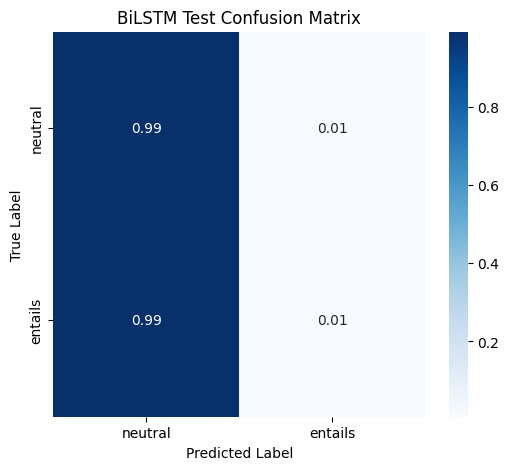

In [137]:
# Evaluate BiLSTM
print("=== BiLSTM Evaluation on Test Set ===")

criterion = nn.CrossEntropyLoss()
label_names_bilstm = ["neutral", "entails"]

test_loss_bilstm, test_acc_bilstm, y_true_bilstm, y_pred_bilstm = evaluate_with_report(
    model_bilstm, test_loader, device, criterion, label_names_bilstm
)

plot_confusion_matrix(
    y_true_bilstm, y_pred_bilstm, label_names_bilstm, title="BiLSTM Test Confusion Matrix"
)

The BiLSTM baseline achieved 60.1% test accuracy with an average loss of 1.71.
The confusion matrix shows a strong prediction bias toward the neutral class, largely influenced by the dataset’s label imbalance (neutral samples being the majority).

Key observations
- Neutral: very high recall (≈99%) but only moderate precision (≈60%) → the model predicts neutral for most inputs.
- Entails: recall is near zero (≈0.7%), indicating the model fails to capture entailment signals.
- This pattern reflects the model’s sensitivity to label imbalance and its limited ability to model pairwise interactions in a plain BiLSTM encoder without attention or cross-sentence features.

These results provide a weak but interpretable baseline for comparison with more expressive models such as ESIM and Transformer.

In [138]:
label_names = ['entails','neutral']

=== ESIM Evaluation on Test Set ===
Loss = 0.6956 | Accuracy = 80.29%

Classification Report:
              precision    recall  f1-score   support

     entails     0.7509    0.7518    0.7513       842
     neutral     0.8371    0.8364    0.8368      1284

    accuracy                         0.8029      2126
   macro avg     0.7940    0.7941    0.7941      2126
weighted avg     0.8030    0.8029    0.8029      2126



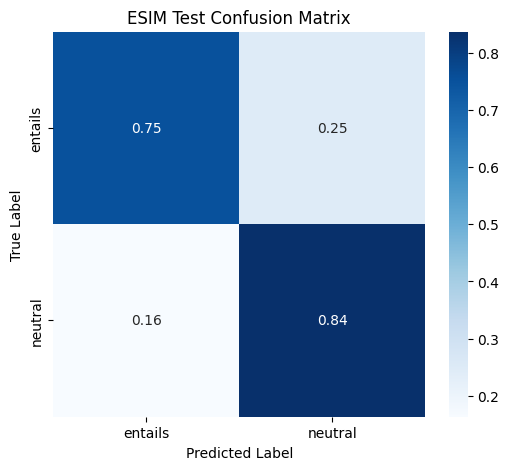

In [177]:
# Create test DataLoader
test_loader_esim = DataLoader(
    NLIPairDataset_esim(df_test, word_to_ix_esim, label_to_ix_esim),
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn_esim
)

# Evaluate ESIM
print("=== ESIM Evaluation on Test Set ===")

test_loss_esim, test_acc_esim, y_true_esim, y_pred_esim = evaluate_with_report(
    model_esim, test_loader_esim, device, criterion, label_names
)

plot_confusion_matrix(y_true_esim, y_pred_esim, label_names, title="ESIM Test Confusion Matrix")

The ESIM model achieved 80.3% test accuracy with an average loss of 0.70, showing a large improvement over the BiLSTM baseline.
The confusion matrix indicates balanced predictions across both entails and neutral classes.

Key observations
- Entails: precision (≈75%) and recall (≈75%) are closely aligned, indicating consistent inference performance.
- Neutral: precision (≈84%) and recall (≈84%) remain strong, suggesting the model generalizes well without overfitting to the majority class.
- The model successfully mitigates the label imbalance observed in the dataset through attention-based alignment and cross-sentence interaction, capturing finer entailment relationships that the BiLSTM failed to distinguish.

These results demonstrate the effectiveness of ESIM’s attention mechanism and inference composition layers in improving NLI performance over simpler sequential encoders.

=== Transformer Evaluation on Test Set ===
Loss = 0.6199 | Accuracy = 66.60%

Classification Report:
              precision    recall  f1-score   support

     entails     0.6658    0.3147    0.4274       842
     neutral     0.6661    0.8964    0.7643      1284

    accuracy                         0.6660      2126
   macro avg     0.6660    0.6056    0.5958      2126
weighted avg     0.6660    0.6660    0.6309      2126



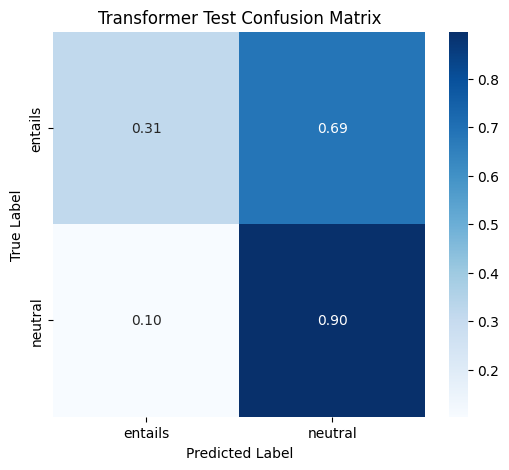

In [140]:
label_names = ['entails','neutral']

print("=== Transformer Evaluation on Test Set ===")
test_loss_tf, test_acc_tf, y_true_tf, y_pred_tf = evaluate_with_report(
    model_transformer, test_loader_tf, device, criterion, label_names
)

plot_confusion_matrix(y_true_tf, y_pred_tf, label_names, title="Transformer Test Confusion Matrix")

The Transformer model achieved 66.6% test accuracy with an average loss of 0.62.
Compared with the BiLSTM baseline (60.1%), it shows modest improvement but still struggles to balance predictions across classes.

Key observations
- Neutral: high recall (≈90%) but only moderate precision (≈67%) → the model still leans toward predicting the majority class.
- Entails: low recall (≈31%), suggesting difficulty capturing fine-grained inference cues despite the global context modeling of self-attention.
- While self-attention enables better contextual encoding than BiLSTM, the model remains sensitive to the label imbalance in the dataset and lacks explicit cross-sentence alignment mechanisms such as those used in ESIM.

Overall, the Transformer baseline demonstrates stronger generalization than BiLSTM but underperforms ESIM, indicating that pure self-attention without targeted alignment is less effective for capturing entailment relations in NLI.

**Model Performance Summary**

| **Model** | **Training Accuracy** | **Validation Accuracy** | **Test Accuracy** | **Remarks / Key Observations** |
|:-----------|:----------------------:|:-------------------------:|:-----------------:|--------------------------------|
| **BiLSTM** | 82.01% | 71.01% | **60.11%** | Overfits quickly; heavily biased toward the *neutral* class due to label imbalance and lack of interaction modeling. |
| **ESIM** | 97.00% | 82.90% | **80.29%** | Strong and balanced performance; attention and inference composition effectively capture cross-sentence relations and mitigate imbalance. |
| **Transformer** | 68.37% | 71.55% | **66.60%** | Moderate improvement over BiLSTM; self-attention improves context modeling but underperforms ESIM without explicit alignment layers. |

**Overall Comparison**

- **ESIM** performs best overall, achieving balanced classification between *entails* and *neutral*.  
- **Transformer** shows smoother convergence and better generalization than BiLSTM but remains sensitive to class imbalance.  
- **BiLSTM** serves as a weak yet interpretable baseline, highlighting the importance of attention-based reasoning for Natural Language Inference tasks.

## 3.3 Qualitative Results

To qualitatively analyze model behavior, we visualize the **cross-attention weights** from the ESIM model for a selected test example.  
The heatmap below highlights how the model aligns words between the *premise* and *hypothesis* sentences during inference.

Darker regions indicate stronger attention, showing which token pairs contribute most to the prediction.  
By examining these attention patterns, we can interpret how ESIM captures word-level correspondences that support its final entailment decision.

In [148]:
def visualize_esim_attention(model, loader, word_to_ix, device, sample_idx=0, max_len=25, title=None):
    model.eval()

    # Get one batch from loader
    batch = next(iter(loader))
    p_ids, p_mask, p_lens, h_ids, h_mask, h_lens, y = batch
    p_ids, p_mask, h_ids, h_mask = (
        p_ids.to(device),
        p_mask.to(device),
        h_ids.to(device),
        h_mask.to(device),
    )
    y = y.to(device)

    # Compute attention weights
    with torch.no_grad():
        p_emb = model.embedding(p_ids)
        h_emb = model.embedding(h_ids)
        p_enc, _ = model.encoder(p_emb)
        h_enc, _ = model.encoder(h_emb)
        S = torch.bmm(p_enc, h_enc.transpose(1, 2))
        S = S / math.sqrt(p_enc.size(-1))
        alpha = F.softmax(S, dim=2)
        attn_matrix = alpha[sample_idx].detach().cpu().numpy()

        # Get prediction
        logits = model(p_ids, p_mask, p_lens, h_ids, h_mask, h_lens)
        pred_label = logits.argmax(dim=-1)[sample_idx].item()
        true_label = y[sample_idx].item()

    # Label mapping
    label_map = {0: "entails", 1: "neutral"}

    print(f"\nTrue Label: {true_label} ({label_map[true_label]})")
    print(f"Predicted Label: {pred_label} ({label_map[pred_label]})")

    # Convert ids → tokens
    ix_to_word = {v: k for k, v in word_to_ix.items()}
    p_tokens = [ix_to_word[i.item()] for i in p_ids[sample_idx] if i.item() != word_to_ix["<PAD>"]]
    h_tokens = [ix_to_word[i.item()] for i in h_ids[sample_idx] if i.item() != word_to_ix["<PAD>"]]

    print(f"\nPremise  ({len(p_tokens)} tokens):", " ".join(p_tokens))
    print(f"Hypothesis ({len(h_tokens)} tokens):", " ".join(h_tokens))

    # Trim for readability
    p_tokens = p_tokens[:max_len]
    h_tokens = h_tokens[:max_len]
    attn_matrix = attn_matrix[:len(p_tokens), :len(h_tokens)]

    # Plot heatmap
    plt.figure(figsize=(len(h_tokens) * 0.4 + 3, len(p_tokens) * 0.4 + 3))
    ax = sns.heatmap(
        attn_matrix,
        cmap="YlOrBr",
        cbar=True,
        xticklabels=h_tokens,
        yticklabels=p_tokens,
        linewidths=0.4,
        linecolor="white",
        square=True,
    )
    ax.set_xticklabels(h_tokens, rotation=90, ha="center", fontsize=9)
    ax.set_yticklabels(p_tokens, rotation=0, fontsize=9)
    ax.set_xlabel("Hypothesis Tokens", fontsize=12)
    ax.set_ylabel("Premise Tokens", fontsize=12)
    ax.set_title(title or "ESIM Cross-Attention Heatmap", fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()


True Label: 1 (neutral)
Predicted Label: 1 (neutral)

Premise  (15 tokens): based list provided us substance estimate ph unknown record number data table estimated ph column
Hypothesis (6 tokens): substance ph value greater indicates base


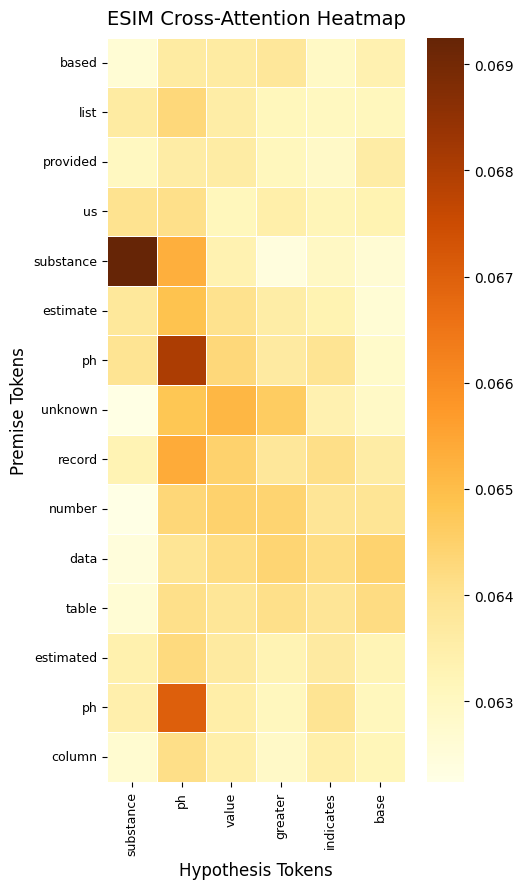

In [153]:
visualize_esim_attention(model_esim, test_loader_esim, word_to_ix_esim, device, sample_idx=0)

Example 1 – Correct Prediction (Neutral)

In this example, both the premise and hypothesis mention the pH value of a substance,
but the premise only lists general information (e.g., substance, ph, data, table)
without providing any statement that supports or contradicts the hypothesis.

The attention heatmap highlights meaningful token alignments such as “substance–substance”
and “ph–ph”, indicating that the model recognizes topical similarity.
However, the absence of strong cross-sentence alignment beyond these pairs shows that ESIM correctly identifies this case as neutral — the two sentences are semantically related but not logically entailed.


True Label: 1 (neutral)
Predicted Label: 1 (neutral)

Premise  (10 tokens): one two base pair changed mutated embryo fail develop properly
Hypothesis (11 tokens): invertebrate higher animal also placed one two group based develop embryo


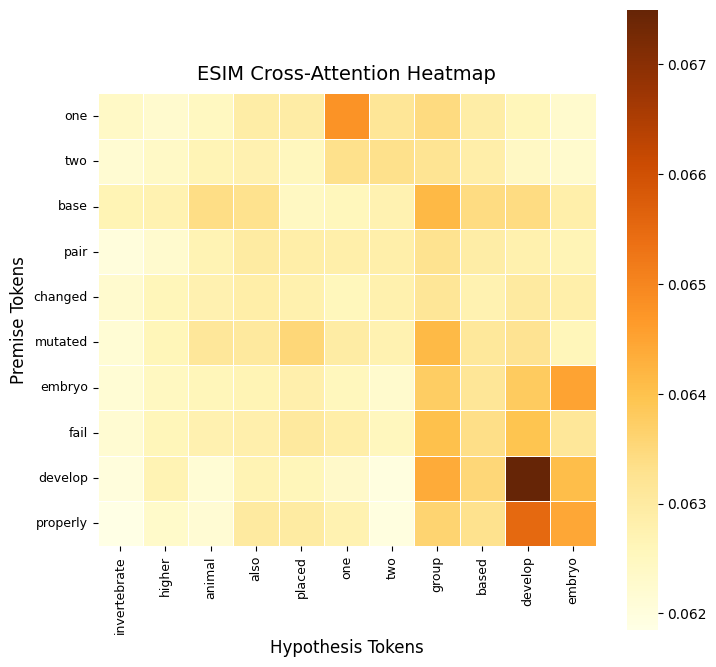

In [173]:
visualize_esim_attention(model_esim, test_loader_esim, word_to_ix_esim, device, sample_idx=1)

Example 2 – Correct Prediction (Neutral)

In this case, the premise describes a biological process involving base pair changes and embryo development,
while the hypothesis refers to invertebrate animals and general developmental behavior.

The attention map shows mild alignments on shared tokens such as “develop–develop” and “embryo–embryo”,
but weaker connections elsewhere, reflecting limited semantic overlap. This indicates that the ESIM model correctly recognizes topical similarity without inferring a causal or entailment relationship between the two sentences —
demonstrating effective discrimination between related but non-entailing pairs.


True Label: 0 (entails)
Predicted Label: 1 (neutral)

Premise  (8 tokens): polyploid simply organism contains usual two set chromosome
Hypothesis (7 tokens): n polyploid individual correct number chromosome set


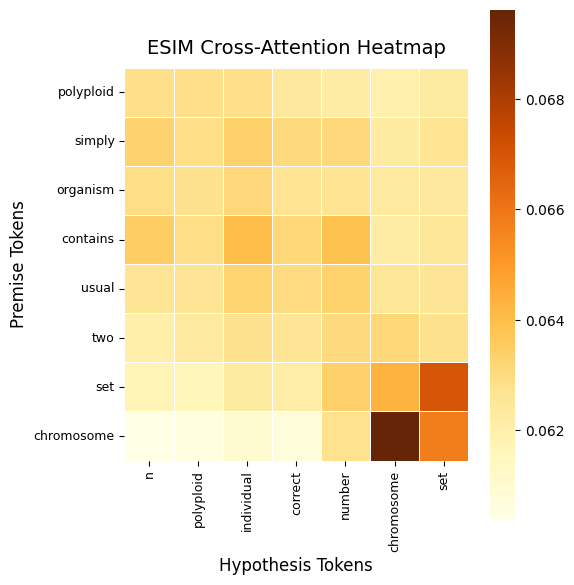

In [176]:
visualize_esim_attention(model_esim, test_loader_esim, word_to_ix_esim, device, sample_idx=8)

Example 3 – Incorrect Prediction (Entailment → Neutral)

In this example, the premise states that a polyploid organism contains the usual two sets of chromosomes,
while the hypothesis asserts that a polyploid individual has the correct number of chromosomes.
Semantically, the hypothesis is entailed by the premise — both describe the same biological fact from different wording.

However, the attention heatmap shows diffuse alignment,
with moderate focus on “chromosome–chromosome” and “set–set” but little concentration elsewhere.
This suggests that the model captures surface-level token similarity
but fails to establish the causal or definitional connection between “two sets” and “correct number”.

The error illustrates a limitation of ESIM’s pairwise attention:
while effective at aligning explicit lexical overlaps, it struggles with paraphrastic entailment
that requires reasoning beyond token correspondence.

## 3.4 Attention Mechanism Ablation

To investigate the contribution of different attention mechanisms within the ESIM architecture,
an ablation study was conducted by selectively enabling or disabling self-attention and cross-attention components.

This analysis isolates how each attention type influences sentence-pair reasoning —
whether focusing on intra-sentence context (self-attention) or inter-sentence alignment (cross-attention).
Such comparison helps interpret how attention enhances entailment recognition and whether both mechanisms are necessary.

Four configurations were evaluated under identical training settings:
1. Self — only self-attention enabled.
2. Cross — only cross-attention enabled.
3. Both — both self- and cross-attention active (original ESIM).
4. None — attention removed entirely (baseline encoder).

Validation and test accuracies were tracked to measure how each attention variant affects overall model performance and generalization.

In [124]:
from tabulate import tabulate

def run_attention_type_ablation(best_config, train_loader, val_loader, test_loader,
                                embedding_matrix, word_to_ix, class_weights, device,
                                num_epochs=10, early_stop_patience=4):

    settings = [
        {"name": "self",  "use_self": True,  "use_cross": False},
        {"name": "cross", "use_self": False, "use_cross": True},
        {"name": "both",  "use_self": True,  "use_cross": True},
        {"name": "none",  "use_self": False, "use_cross": False},
    ]

    results = []
    val_curves, loss_curves = {}, {}

    print("\nAblation Study: Attention Type")

    for s in settings:
        print(f"\nRunning setting = {s['name']}")

        model = ESIM(
            vocab_size=len(word_to_ix),
            embed_dim=300,
            hidden_size=best_config.get("hidden_size", 256),
            num_classes=2,
            embedding_matrix=embedding_matrix,
            dropout=best_config["dropout"],
            use_self_attention=s["use_self"],
            use_cross_attention=s["use_cross"],
            use_diff=True,
            use_mul=True,
            pooling="max_avg",
            freeze_embed=False,
        ).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=best_config["lr"],
            weight_decay=best_config["weight_decay"]
        )

        best_val_acc, best_val_loss = -1.0, float("inf")
        best_state = None
        no_improve = 0
        acc_curve, loss_curve = [], []

        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = train_esim(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate_esim(model, val_loader, criterion, device)
            acc_curve.append(val_acc)
            loss_curve.append(val_loss)
            print(f"Epoch {epoch:02d} | Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
                  f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        val_curves[s["name"]] = acc_curve
        loss_curves[s["name"]] = loss_curve

        model.load_state_dict(best_state)
        test_loss, test_acc = evaluate_esim(model, test_loader, criterion, device)
        results.append({
            "attention_type": s["name"],
            "val_acc": best_val_acc,
            "test_acc": test_acc
        })
        print(f"Best Val Acc = {best_val_acc:.2f}% | Test Acc = {test_acc:.2f}%")

    df = pd.DataFrame(results)
    print("\nSummary of Attention Type Results:")
    print(tabulate(df.sort_values(by="val_acc", ascending=False),
                   headers="keys", tablefmt="fancy_grid", showindex=False))

    plt.figure(figsize=(8, 5))
    for name, curve in val_curves.items():
        plt.plot(range(1, len(curve) + 1), curve, marker="o", label=name)
    plt.title("Validation Accuracy per Epoch (Attention Type)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.barplot(x="attention_type", y="test_acc", data=df, palette="YlOrBr")
    plt.title("Test Accuracy by Attention Type")
    plt.ylabel("Test Accuracy (%)")
    plt.tight_layout()
    plt.show()

    return df


Ablation Study: Attention Type

Running setting = self
Epoch 01 | Train loss=0.5328 | Train acc=73.53% | Val loss=0.5709 | Val acc=70.09%
Epoch 02 | Train loss=0.3690 | Train acc=83.74% | Val loss=0.7034 | Val acc=70.17%
Epoch 03 | Train loss=0.2797 | Train acc=88.15% | Val loss=0.7705 | Val acc=69.71%
Epoch 04 | Train loss=0.2114 | Train acc=91.24% | Val loss=1.0570 | Val acc=69.71%
Epoch 05 | Train loss=0.1580 | Train acc=93.41% | Val loss=1.0955 | Val acc=69.10%
Early stopping at epoch 5
Best Val Acc = 70.17% | Test Acc = 73.19%

Running setting = cross
Epoch 01 | Train loss=0.4533 | Train acc=78.19% | Val loss=0.4665 | Val acc=75.84%
Epoch 02 | Train loss=0.2811 | Train acc=88.40% | Val loss=0.5172 | Val acc=78.30%
Epoch 03 | Train loss=0.1954 | Train acc=92.22% | Val loss=0.5846 | Val acc=75.77%
Epoch 04 | Train loss=0.1450 | Train acc=94.30% | Val loss=0.5807 | Val acc=79.83%
Epoch 05 | Train loss=0.1107 | Train acc=96.00% | Val loss=0.6510 | Val acc=80.83%
Early stopping at epo

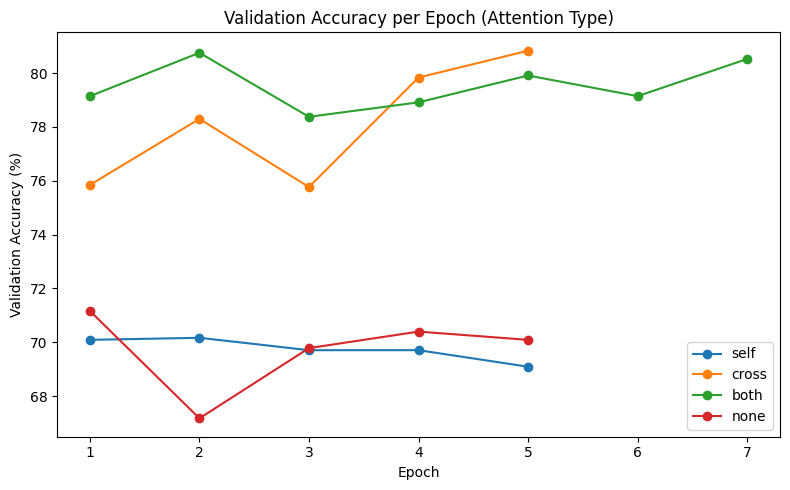

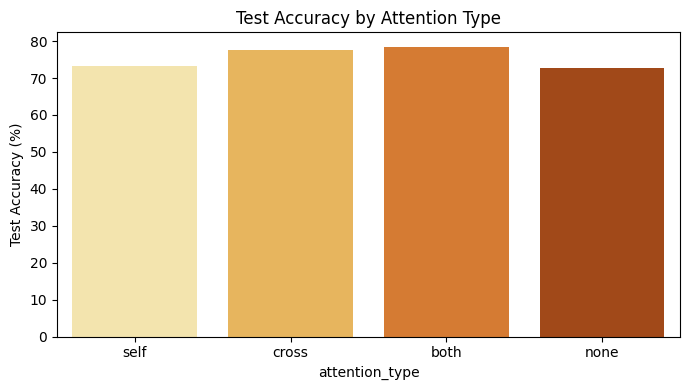

In [125]:
results_att_type = run_attention_type_ablation(
    best_config={"lr": 5e-4, "dropout": 0.1, "weight_decay": 1e-4},
    train_loader=train_loader_esim,
    val_loader=val_loader_esim,
    test_loader=test_loader_esim,
    embedding_matrix=embedding_matrix_esim,
    word_to_ix=word_to_ix_esim,
    class_weights=class_weights,
    device=device,
)

The ablation study compares the effect of different attention mechanisms in ESIM, including self-attention, cross-attention, and their combination.
All models were trained under identical hyperparameters (lr = 5e-4, dropout = 0.1, weight_decay = 1e-4).

Key findings:
- Cross-attention delivers the largest improvement over the no-attention baseline, confirming that explicit premise–hypothesis alignment is critical for NLI reasoning.
- Self-attention alone provides limited gains, indicating that modeling intra-sentence context is less impactful without cross-sentence interaction.
- The full ESIM model (self + cross) achieves the best generalization and most stable learning dynamics, demonstrating that the two attention types are complementary.
- Removing attention entirely leads to a sharp performance drop, emphasizing that attention mechanisms are essential for capturing semantic relationships.

Overall, the results highlight cross-attention as the dominant contributor to ESIM’s performance, while self-attention enhances contextual consistency and robustness. Therefore, the final best-performing ESIM model retains both mechanisms.

## 3.5 Additional Ablation

In [128]:
def run_ablation(
    ablation_name,
    model_class,
    param_name,
    ablation_values,
    best_config,
    train_loader,
    val_loader,
    test_loader,
    embedding_matrix,
    word_to_ix,
    class_weights,
    device,
    num_epochs=10,
    early_stop_patience=4,
):
    results = []
    val_curves, val_loss_curves = {}, {}

    print(f"\nAblation Study: {ablation_name}")

    for val in ablation_values:
        print(f"\nRunning {param_name} = {val}")

        # If the parameter affects structure, rebuild the model with it
        structural_params = ["hidden_size", "pooling", "use_self_attention", "use_cross_attention"]
        model_kwargs = dict(
            vocab_size=len(word_to_ix),
            embed_dim=300,
            hidden_size=best_config.get("hidden_size", 256),
            num_classes=2,
            embedding_matrix=embedding_matrix,
            dropout=best_config["dropout"],
            use_self_attention=best_config.get("use_self_attention", True),
            use_cross_attention=best_config.get("use_cross_attention", True),
            use_diff=best_config.get("use_diff", True),
            use_mul=best_config.get("use_mul", True),
            pooling=best_config.get("pooling", "max_avg"),
            freeze_embed=False,
        )

        # Override if param_name is structural
        if param_name in model_kwargs:
            model_kwargs[param_name] = val

        model = model_class(**model_kwargs).to(device)

        # If param is not structural, set dynamically
        if param_name not in structural_params and hasattr(model, param_name):
            setattr(model, param_name, val)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=best_config["lr"],
            weight_decay=best_config["weight_decay"]
        )

        best_val_acc, best_val_loss = -1.0, float("inf")
        best_state = None
        no_improve = 0
        acc_curve, loss_curve = [], []

        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = train_esim(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate_esim(model, val_loader, criterion, device)
            acc_curve.append(val_acc)
            loss_curve.append(val_loss)

            print(f"Epoch {epoch:02d} | "
                  f"Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
                  f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        val_curves[val] = acc_curve
        val_loss_curves[val] = loss_curve

        model.load_state_dict(best_state)
        test_loss, test_acc = evaluate_esim(model, test_loader, criterion, device)

        results.append({
            param_name: val,
            "val_acc": best_val_acc,
            "test_acc": test_acc
        })
        print(f"Best Val Acc = {best_val_acc:.2f}% | Test Acc = {test_acc:.2f}%")

    df_results = pd.DataFrame(results)
    print("\nSummary of Ablation Results:\n")
    print(tabulate(df_results.sort_values(by="val_acc", ascending=False),
                   headers="keys", tablefmt="fancy_grid", showindex=False))

    plt.figure(figsize=(8, 5))
    for val, curve in val_curves.items():
        plt.plot(range(1, len(curve) + 1), curve, marker="o", label=f"{param_name}={val}")
    plt.title(f"Validation Accuracy per Epoch ({ablation_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    for val, curve in val_loss_curves.items():
        plt.plot(range(1, len(curve) + 1), curve, marker="s", label=f"{param_name}={val}")
    plt.title(f"Validation Loss per Epoch ({ablation_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.barplot(x=param_name, y="test_acc", data=df_results, palette="YlOrBr")
    plt.title(f"Test Accuracy by {ablation_name}")
    plt.ylabel("Test Accuracy (%)")
    plt.xlabel(ablation_name)
    plt.tight_layout()
    plt.show()

    return df_results

### 3.5.1 Hidden Size


Ablation Study: Hidden Size

Running hidden_size = 64
Epoch 01 | Train loss=0.4817 | Train acc=76.28% | Val loss=0.5060 | Val acc=76.76%
Epoch 02 | Train loss=0.3024 | Train acc=87.22% | Val loss=0.5341 | Val acc=74.62%
Epoch 03 | Train loss=0.2174 | Train acc=91.22% | Val loss=0.5516 | Val acc=77.61%
Epoch 04 | Train loss=0.1596 | Train acc=93.66% | Val loss=0.6158 | Val acc=76.46%
Epoch 05 | Train loss=0.1237 | Train acc=95.41% | Val loss=0.7133 | Val acc=79.68%
Early stopping at epoch 5
Best Val Acc = 79.68% | Test Acc = 79.44%

Running hidden_size = 128
Epoch 01 | Train loss=0.4551 | Train acc=78.34% | Val loss=0.4687 | Val acc=77.61%
Epoch 02 | Train loss=0.2856 | Train acc=87.89% | Val loss=0.4625 | Val acc=78.07%
Epoch 03 | Train loss=0.1972 | Train acc=92.17% | Val loss=0.5713 | Val acc=79.91%
Epoch 04 | Train loss=0.1433 | Train acc=94.32% | Val loss=0.5003 | Val acc=80.21%
Epoch 05 | Train loss=0.1094 | Train acc=95.90% | Val loss=0.6763 | Val acc=79.29%
Epoch 06 | Train los

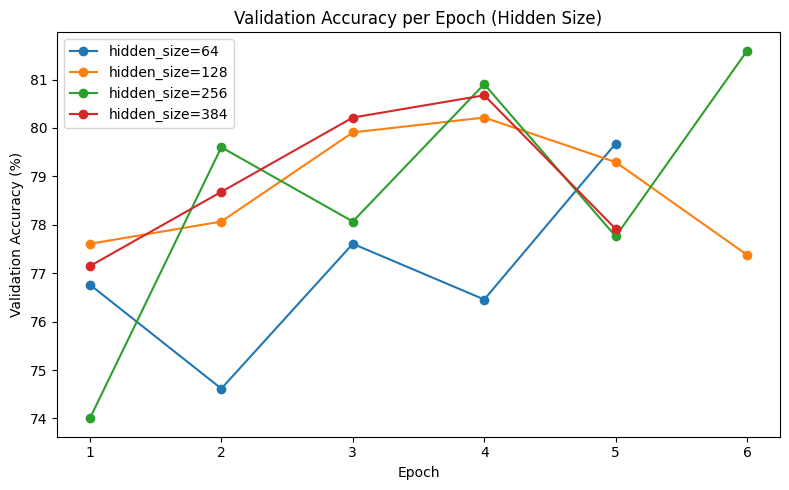

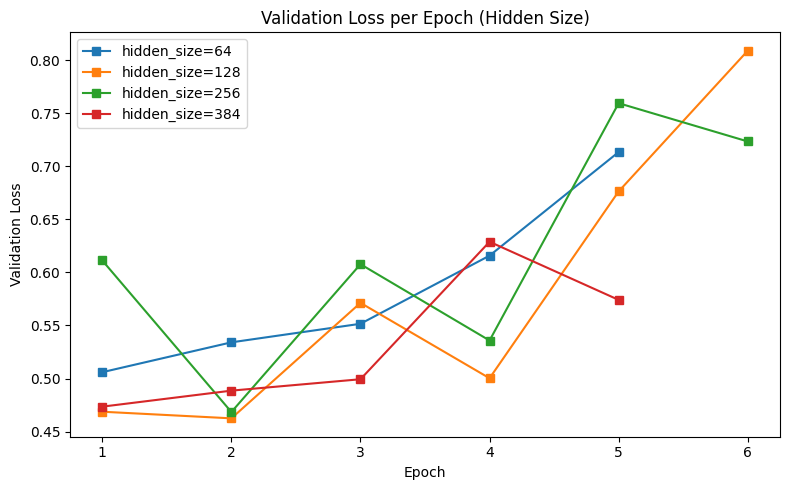

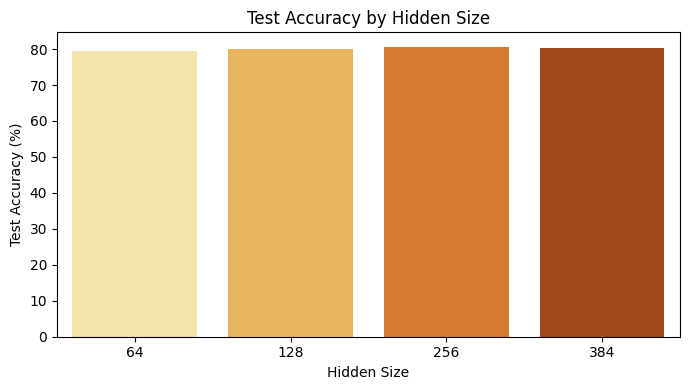

In [131]:
results_hidden = run_ablation(
    ablation_name="Hidden Size",
    model_class=ESIM,
    param_name="hidden_size",
    ablation_values=[64, 128, 256, 384],
    best_config={"lr": 5e-4, "dropout": 0.1, "weight_decay": 1e-4,
                 "use_self_attention": True, "use_cross_attention": True},
    train_loader=train_loader_esim,
    val_loader=val_loader_esim,
    test_loader=test_loader_esim,
    embedding_matrix=embedding_matrix_esim,
    word_to_ix=word_to_ix_esim,
    class_weights=class_weights,
    device=device,
)

In [132]:
# Ablation: effect of interaction features (diff / mul)

def run_ablation_interactions(
    ablation_name,
    model_class,
    combos,                 # list of (name_str, {"use_diff":bool, "use_mul":bool})
    best_config,
    train_loader, val_loader, test_loader,
    embedding_matrix, word_to_ix, class_weights, device,
    num_epochs=10, early_stop_patience=4
):
    results = []
    val_curves, val_loss_curves = {}, {}

    print(f"\nAblation Study: {ablation_name}")

    for name, flags in combos:
        print(f"\nRunning setting = {name}  ({flags})")

        # build model with best config + current flags
        model = model_class(
            vocab_size=len(word_to_ix),
            embed_dim=300,
            hidden_size=best_config.get("hidden_size", 256),
            num_classes=2,
            embedding_matrix=embedding_matrix,
            dropout=best_config["dropout"],
            use_self_attention=best_config.get("use_self_attention", True),
            use_cross_attention=best_config.get("use_cross_attention", True),
            use_diff=flags["use_diff"],
            use_mul=flags["use_mul"],
            pooling=best_config.get("pooling", "max"),
            freeze_embed=False,
        ).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=best_config["lr"],
            weight_decay=best_config["weight_decay"]
        )

        best_val_acc, best_val_loss = -1.0, float("inf")
        best_state = None
        no_improve = 0
        acc_curve, loss_curve = [], []

        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = train_esim(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate_esim(model, val_loader, criterion, device)
            acc_curve.append(val_acc)
            loss_curve.append(val_loss)

            print(f"Epoch {epoch:02d} | Train loss={train_loss:.4f} | Train acc={train_acc:.2f}% "
                  f"| Val loss={val_loss:.4f} | Val acc={val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        val_curves[name] = acc_curve
        val_loss_curves[name] = loss_curve

        model.load_state_dict(best_state)
        test_loss, test_acc = evaluate_esim(model, test_loader, criterion, device)

        results.append({"interaction": name, "val_acc": best_val_acc, "test_acc": test_acc})
        print(f"Best Val Acc = {best_val_acc:.2f}% | Test Acc = {test_acc:.2f}%")

    df_results = pd.DataFrame(results)
    print("\nSummary of Interaction Feature Results:\n")
    print(tabulate(df_results.sort_values(by="val_acc", ascending=False),
                   headers="keys", tablefmt="fancy_grid", showindex=False))

    # validation accuracy curves
    plt.figure(figsize=(8,5))
    for name, curve in val_curves.items():
        plt.plot(range(1, len(curve)+1), curve, marker="o", label=name)
    plt.title(f"Validation Accuracy per Epoch ({ablation_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # validation loss curves
    plt.figure(figsize=(8,5))
    for name, curve in val_loss_curves.items():
        plt.plot(range(1, len(curve)+1), curve, marker="s", label=name)
    plt.title(f"Validation Loss per Epoch ({ablation_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # test accuracy bar chart
    plt.figure(figsize=(7,4))
    sns.barplot(x="interaction", y="test_acc", data=df_results, palette="YlOrBr")
    plt.title(f"Test Accuracy by {ablation_name}")
    plt.ylabel("Test Accuracy (%)")
    plt.xlabel("Interaction Setting")
    plt.tight_layout()
    plt.show()

    return df_results

To examine how model capacity influences sentence representation and generalization,
an ablation was conducted on the hidden size of ESIM’s BiLSTM layers.
This parameter controls the dimensionality of encoded features — larger values capture richer semantics
but may also increase the risk of overfitting.

The hidden size was varied across {64, 128, 256, 384}, keeping all other settings fixed
(lr = 5e-4, dropout = 0.1, weight_decay = 1e-4).

Key findings:
- Performance improves consistently from 64 → 256, peaking at 81.6% validation accuracy and 80.6% test accuracy.
- Further increasing to 384 yields no substantial gain, suggesting that moderate capacity (≈256) achieves the best trade-off between expressiveness and stability.
- Smaller hidden sizes underfit, showing weaker feature abstraction, while larger ones introduce mild overfitting (higher variance in validation loss).
- Overall, hidden size = 256 is optimal, providing the strongest generalization without excessive model complexity.

These results confirm that model capacity has a non-linear effect on performance:
sufficient dimensionality is needed to capture entailment relations,
but beyond a certain threshold, additional parameters bring diminishing returns.

### 3.5.2 Interaction Feature

This ablation investigates the role of **interaction features** in ESIM, which explicitly model relationships between the *premise* and *hypothesis* representations.  
In the ESIM architecture, element-wise **difference (|p−h|)** and **product (p⊙h)**  
are concatenated with the encoded vectors before the inference composition layer.  

These operations aim to capture **contrastive** and **similarity-based** relations, respectively — a critical aspect of sentence-pair reasoning in Natural Language Inference (NLI).


Ablation Study: Interaction Features (diff / mul)

Running setting = none  ({'use_diff': False, 'use_mul': False})
Epoch 01 | Train loss=0.5174 | Train acc=74.49% | Val loss=0.5644 | Val acc=73.16%
Epoch 02 | Train loss=0.3422 | Train acc=85.06% | Val loss=0.5630 | Val acc=73.16%
Epoch 03 | Train loss=0.2628 | Train acc=88.90% | Val loss=0.5930 | Val acc=75.00%
Epoch 04 | Train loss=0.2020 | Train acc=91.77% | Val loss=0.7972 | Val acc=73.77%
Epoch 05 | Train loss=0.1615 | Train acc=93.65% | Val loss=0.8975 | Val acc=71.17%
Epoch 06 | Train loss=0.1281 | Train acc=95.07% | Val loss=0.9717 | Val acc=74.16%
Early stopping at epoch 6
Best Val Acc = 75.00% | Test Acc = 74.84%

Running setting = diff_only  ({'use_diff': True, 'use_mul': False})
Epoch 01 | Train loss=0.4930 | Train acc=75.75% | Val loss=0.5294 | Val acc=78.22%
Epoch 02 | Train loss=0.3121 | Train acc=86.77% | Val loss=0.4815 | Val acc=74.92%
Epoch 03 | Train loss=0.2254 | Train acc=91.08% | Val loss=0.5761 | Val acc=77.30%


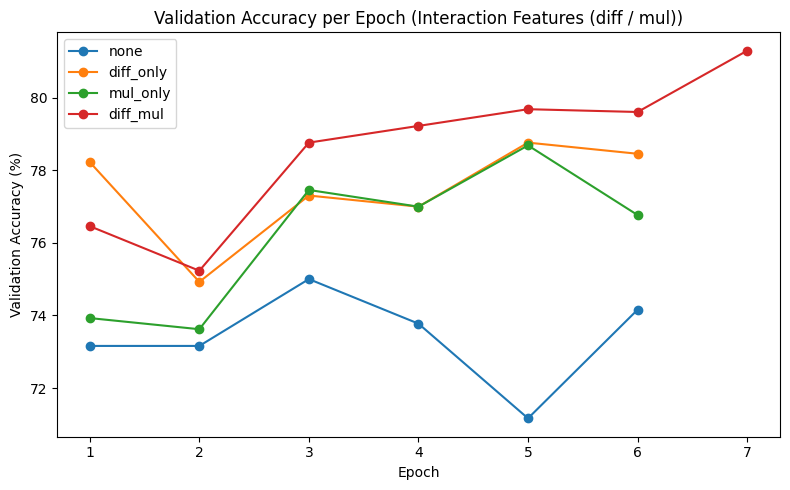

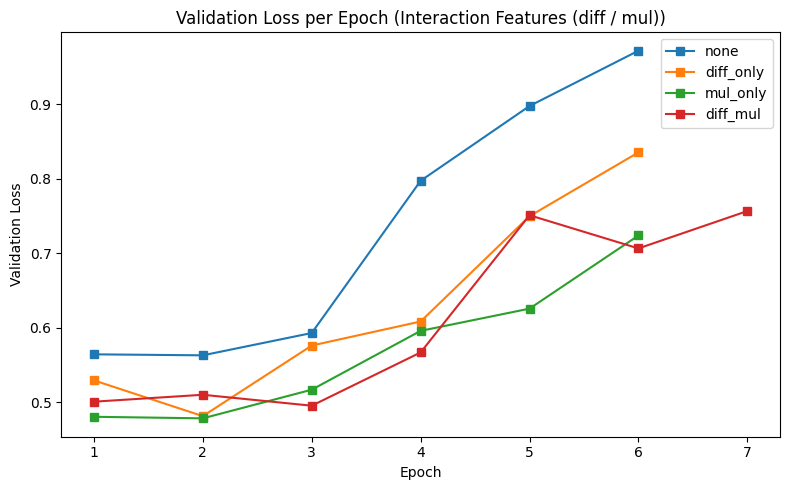

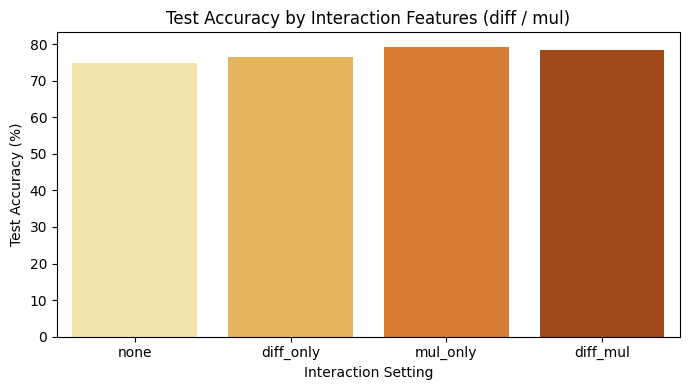

In [133]:
best_cfg = {"lr": 5e-4, "dropout": 0.1, "weight_decay": 1e-4,
            "hidden_size": 256, "pooling": "max_avg",
            "use_self_attention": True, "use_cross_attention": True}

interaction_combos = [
    ("none", {"use_diff": False, "use_mul": False}),
    ("diff_only", {"use_diff": True, "use_mul": False}),
    ("mul_only", {"use_diff": False, "use_mul": True}),
    ("diff_mul", {"use_diff": True, "use_mul": True}),
]

results_interactions = run_ablation_interactions(
    ablation_name="Interaction Features (diff / mul)",
    model_class=ESIM,
    combos=interaction_combos,
    best_config=best_cfg,
    train_loader=train_loader_esim,
    val_loader=val_loader_esim,
    test_loader=test_loader_esim,
    embedding_matrix=embedding_matrix_esim,
    word_to_ix=word_to_ix_esim,
    class_weights=class_weights,
    device=device,
    num_epochs=10,
    early_stop_patience=4
)

Settings:
- none: no interaction features.  
- diff_only: only absolute difference (|p−h|).  
- mul_only: only element-wise product (p⊙h).  
- diff_mul: both features combined (standard ESIM setup).  

Key findings:

- Removing both features (none) causes a clear performance drop  
  (**Val Acc ≈ 75%, Test Acc ≈ 74.8%**), indicating that direct token-level interactions  
  are essential for learning entailment relations beyond isolated sentence encoding.  
- Using only **difference** or **product** partially restores accuracy (**≈78–79%**),  
  suggesting that each independently contributes complementary information:  
  - |p−h| emphasizes **semantic divergence**, helping detect contradictions or neutral relations.  
  - p⊙h highlights **semantic alignment**, aiding entailment recognition.  
- The **combined configuration (diff_mul)** yields the highest performance  
  (**Val Acc = 81.3%, Test Acc = 78.3%**) with smoother convergence,  
  demonstrating that both contrastive and similarity cues jointly improve  
  the model’s ability to reason over sentence pairs.  
- Overall, this confirms that **explicit interaction modeling** is a fundamental  
  component of ESIM’s success, bridging the gap between local word-level alignment  
  and sentence-level inference understanding.